In [3]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
import matplotlib.font_manager
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import mlflow


figure(num=None, figsize=(5, 5), dpi=100)
sns.set_context("paper", rc={'axes.labelsize': 42.6,
        'axes.titlesize': 57.2,
        'font.size': 48.2,
        'grid.linewidth': 1.6,
        'legend.fontsize': 16.0,
        'lines.linewidth': 2.8,
        'lines.markeredgewidth': 0.0,
        'lines.markersize': 11.2,
        'patch.linewidth': 0.48,
        'xtick.labelsize': 42.0,
        'xtick.major.pad': 11.2,
        'xtick.major.width': 1.6,
        'xtick.minor.width': 0.8,
        'ytick.labelsize': 42.0,
        'ytick.major.pad': 11.2,
        'ytick.major.width': 1.6,
        'ytick.minor.width': 0.8}) 
 
sns.set_style('white')
font = {'weight' : 'bold', "size":12, "family":"serif", "serif":"AppleGothic"}
matplotlib.rc('font', **font)

<Figure size 500x500 with 0 Axes>

In [4]:
ROOT_DIR = os.path.abspath('..')
MLRUNS_PATH = os.path.join(ROOT_DIR, 'mlruns')
assert os.path.isdir(MLRUNS_PATH) == True
MLRUNS_PATH

MLFLOW_URI = f'file://{MLRUNS_PATH}'
mlflow.set_tracking_uri(MLFLOW_URI)

def get_experiment(idx):
    result = mlflow.search_runs(experiment_ids=[str(idx)])
    return result

In [5]:
def get_sorted_widths(n_layers):
    widths = list(filter(lambda xs: (',' not in xs) and ('24' not in xs), n_layers.tolist()))
    int_widths = []
    for w in widths:
        values = [int(s) for s in w[1:-1].split(',')]
        int_widths.append(values)
    int_widths = sorted(int_widths)
    widths = [str(d) for d in int_widths]
    return widths


def get_sorted_depths(n_layers, units):
    depths = list(filter(lambda xs: f'{units}' in xs, n_layers.tolist()))
    int_depths = []
    for w in depths:
        values = [int(s) for s in w[1:-1].split(',')]
        int_depths.append(values)
    int_depths = sorted(int_depths)
    depths = [str(d) for d in int_depths]
    return depths

def get_single_ints(widths):
    int_widths = []
    for w in widths:
        w = int(w[1:-1])
        int_widths.append(w)
    return int_widths

# Verification Heat maps

Reproduce the verification heat maps studying how individual fairness changes with the change of $\epsilon$ and model architecture.

Here substitute the EXPERIMENT_ID of the Mlflow experiment created by running the script `certification_experiments.sh`

In [96]:
VERIFICATION_EXPERIMENT_ID = 102

raw_data = get_experiment(VERIFICATION_EXPERIMENT_ID)

### Adult and Crime dataset using Mahalanobis distance

In [97]:
CLASS_DATASET = 'adult'
REG_DATASET = 'crime'
MODEL_NAME = 'vanilla'

In [98]:
class_data = raw_data[(raw_data['params.dataset_name'] == CLASS_DATASET) & (raw_data['params.time_limit'] == '180') & (raw_data['params.dist_metric'] == 'mahalanobis')]
class_epsilons = sorted(class_data['params.verification_epsilon'].unique().tolist(), reverse=True)

class_n_layers = class_data['params.n_units'].unique()
class_widths = get_sorted_widths(class_n_layers)
CLASS_DEPTH_UNITS = 16
class_depths = get_sorted_depths(class_n_layers, CLASS_DEPTH_UNITS)

class_widths_data = class_data[class_data['params.n_units'].isin(class_widths)]

class_depths_data = class_data[class_data['params.n_units'].isin(class_depths)]

class_widths_data_points = []
for eps in class_epsilons:
    row = []
    for w in class_widths:
        d = class_widths_data[(class_widths_data['params.verification_epsilon'] == eps) & (class_widths_data['params.n_units'] == w)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    class_widths_data_points.append(row)
    
    
class_depths_data_points = []
for eps in class_epsilons:
    row = []
    for d in class_depths:
        d = class_depths_data[(class_depths_data['params.verification_epsilon'] == eps) & (class_depths_data['params.n_units'] == d)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    class_depths_data_points.append(row)
        
print(class_widths_data_points)
print(class_depths_data_points)

[[0.9358314762328301, 0.8898622126020447, 0.8203121188141824, 0.9077749830688585], [0.8863223937984763, 0.8841177356176669, 0.8806336254227871, 0.8328996051430712], [0.7240624078934174, 0.748167425544808, 0.7619025836881204, 0.7045042864388684], [0.6052765411549966, 0.6161148502002446, 0.5340155440798475, 0.5943534746087707], [0.3316827674110633, 0.2885980215803198, 0.3641992997146859, 0.28752220297666836], [0.06219861469365734, 0.08397035369303829, 0.06202413902118162, 0.056299903689332575]]
[[0.8898622126020447, 0.8621017749299599, 0.7688910104450843, 0.7839043970591846], [0.8841177356176669, 0.8617393437342135, 0.7508947656242426, 0.7348753682082538], [0.748167425544808, 0.7539972203858714, 0.7081397630137932, 0.6947839696519217], [0.6161148502002446, 0.5576393744135766, 0.5220607184286883, 0.497454568506695], [0.2885980215803198, 0.31173593909801967, 0.27993687038761716, 0.25551463017887593], [0.08397035369303829, 0.06028252604069778, 0.053176607748285615, 0.05248621224842237]]


In [99]:
reg_data = raw_data[(raw_data['params.dataset_name'] == REG_DATASET) & (raw_data['params.time_limit'] == '180') & (raw_data['params.dist_metric'] == 'mahalanobis')]
reg_epsilons = sorted(reg_data['params.verification_epsilon'].unique().tolist(), reverse=True)

reg_n_layers = reg_data['params.n_units'].unique()
reg_widths = get_sorted_widths(reg_n_layers)
REG_DEPTH_UNITS = 16
reg_depths = get_sorted_depths(reg_n_layers, REG_DEPTH_UNITS)

reg_widths_data = reg_data[reg_data['params.n_units'].isin(reg_widths)]

reg_depths_data = reg_data[reg_data['params.n_units'].isin(reg_depths)]

reg_widths_data_points = []
for eps in reg_epsilons:
    row = []
    for w in reg_widths:
        d = reg_widths_data[(reg_widths_data['params.verification_epsilon'] == eps) & (reg_widths_data['params.n_units'] == w)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    reg_widths_data_points.append(row)
    
    
reg_depths_data_points = []
for eps in reg_epsilons:
    row = []
    for d in reg_depths:
        d = reg_depths_data[(reg_depths_data['params.verification_epsilon'] == eps) & (reg_depths_data['params.n_units'] == d)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    reg_depths_data_points.append(row)
        
print(reg_widths_data_points)
print(reg_depths_data_points)

[[0.5928598293741558, 0.5139423023406944, 0.5372059280488909, 0.5303205310162118], [0.5270189533818856, 0.5510930653517176, 0.4895369915986435, 0.47478286697886346], [0.42240682375474936, 0.5087007085013568, 0.45626346489421454, 0.25338567508505283], [0.40757001866484865, 0.34759911466811627, 0.42302500576468643, 0.36300720740672165], [0.35358181495323704, 0.2489180634033591, 0.23641008839712968, 0.2990451172274301], [0.3427609929420239, 0.3456973700242004, 0.29275378073976205, 0.2790525370759969]]
[[0.5139423023406944, 0.32774077486633857, 0.1604828975562919, 0.13081736294032473], [0.5510930653517176, 0.22770308865189828, 0.10570465751663968, 0.1206218220428043], [0.5087007085013568, 0.33802828562771214, 0.08381882780398581, 0.08758019278091494], [0.34759911466811627, 0.27091143873558043, 0.14794173508688707, 0.06544162697733447], [0.2489180634033591, 0.13200743820778543, 0.023534526386085376, 0.05585790914742841], [0.3456973700242004, 0.1056121642872947, 0.059257912286682674, 6.44844

<ipython-input-100-7f56ed447c28>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


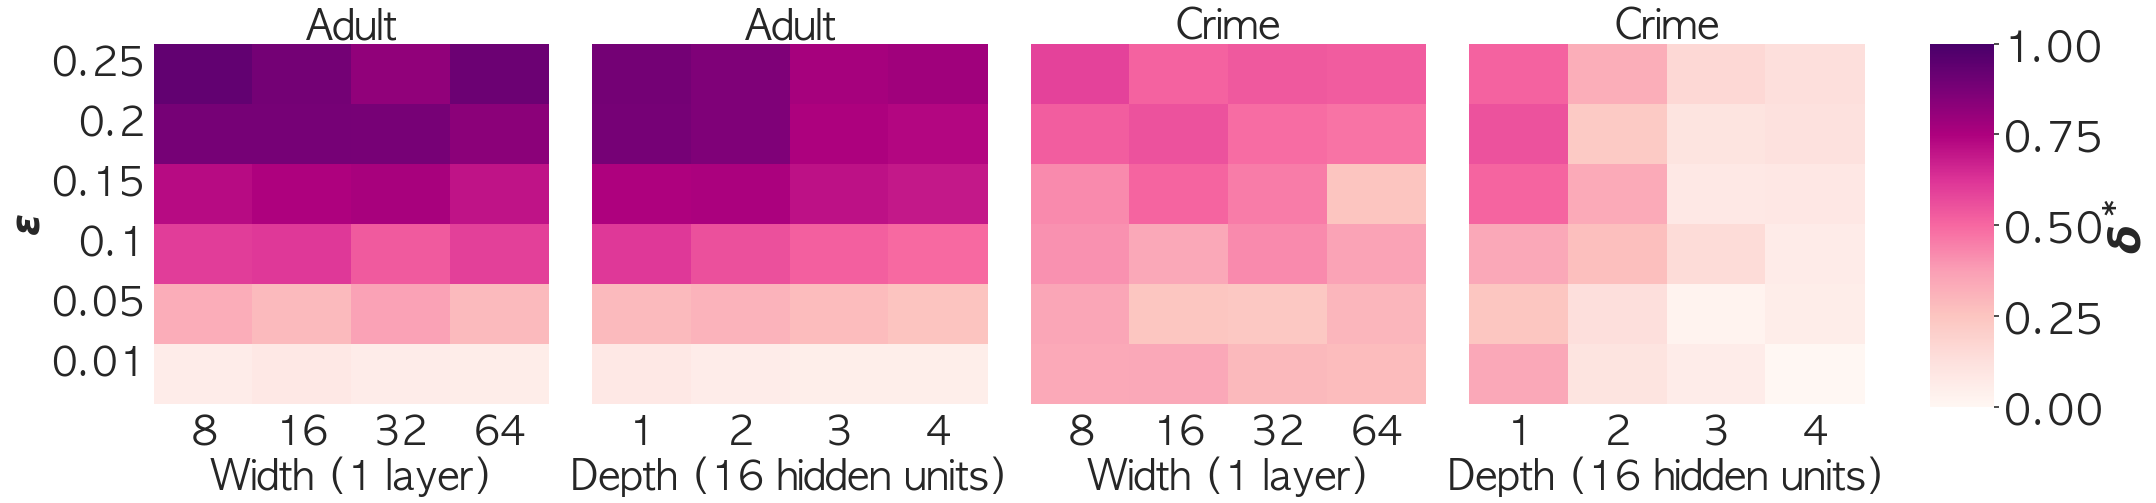

In [100]:
from matplotlib.ticker import MultipleLocator

FONT_SIZE = 40

sns.set_style('white')
font = {'weight' : 'bold', "size":FONT_SIZE, "family":"serif", "serif":"AppleGothic"}
matplotlib.rc('font', **font)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8), sharex=False, sharey=True)
cbar_ax = fig.add_axes([.91, .23, .03, .63])

cmap = sns.cubehelix_palette(start=-1.0, rot=0.8, dark=0.6, light=.95, as_cmap=True)

cmap = sns.color_palette("RdPu", as_cmap=True)


sns.heatmap(class_widths_data_points, cmap=cmap, ax=ax1,  cbar=False, vmin=0, vmax=1, cbar_ax=cbar_ax)

ax1.set_ylabel(r'$\epsilon$', fontsize=FONT_SIZE)
ax1.set_xlabel(r'Width (1 layer)', fontsize=FONT_SIZE)

ax1.set_xticks(np.asarray(range(len(class_widths))) + 0.5)
ax1.set_xticklabels(get_single_ints(class_widths), fontsize=FONT_SIZE, rotation=0)
ax1.set_yticks(np.asarray(range(len(class_epsilons))) + 0.25)
ax1.set_yticklabels(class_epsilons, fontsize=FONT_SIZE, rotation=0)
ax1.set_title('Adult', fontsize=FONT_SIZE)

# ======================

sns.heatmap(class_depths_data_points, cmap=cmap, ax=ax2, vmin=0, vmax=1, cbar_ax=cbar_ax)

ax2.set_ylabel(None)
ax2.set_xlabel(f'Depth ({CLASS_DEPTH_UNITS} hidden units)', fontsize=FONT_SIZE)

ax2.set_xticks(np.asarray(range(len(class_depths))) + 0.5)
ax2.set_xticklabels(range(1, len(class_depths)+1), fontsize=FONT_SIZE, rotation=0)
ax2.set_yticks(np.asarray(range(len(class_epsilons))) + 0.25)
ax2.set_yticklabels(class_epsilons, fontsize=FONT_SIZE, rotation=0)
ax2.set_title('Adult', fontsize=FONT_SIZE)


# ==================

sns.heatmap(reg_widths_data_points, cmap=cmap, ax=ax3,  cbar=False, vmin=0, vmax=1, cbar_ax=cbar_ax)

ax3.set_ylabel(None)
ax3.set_xlabel(r'Width (1 layer)', fontsize=FONT_SIZE)

ax3.set_xticks(np.asarray(range(len(reg_widths))) + 0.5)
ax3.set_xticklabels(get_single_ints(reg_widths), fontsize=FONT_SIZE, rotation=0)
ax3.set_yticks(np.asarray(range(len(reg_epsilons))) + 0.25)
ax3.set_yticklabels(reg_epsilons, fontsize=FONT_SIZE, rotation=0)
ax3.set_title('Crime', fontsize=FONT_SIZE)

# ======================

sns.heatmap(reg_depths_data_points, cmap=cmap, ax=ax4, vmin=0, vmax=1, cbar_ax=cbar_ax, cbar_kws={'label': r'$\delta^*$'})

ax4.set_ylabel(None)
ax4.set_xlabel(f'Depth ({REG_DEPTH_UNITS} hidden units)', fontsize=FONT_SIZE)

ax4.set_xticks(np.asarray(range(len(reg_depths))) + 0.5)
ax4.set_xticklabels(range(1, len(reg_depths)+1), fontsize=FONT_SIZE, rotation=0)
ax4.set_yticks(np.asarray(range(len(reg_epsilons))) + 0.25)
ax4.set_yticklabels(reg_epsilons, fontsize=FONT_SIZE, rotation=0)
ax4.set_title('Crime', fontsize=FONT_SIZE)

# ======================

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(f'figure_1_mahalanobis.jpeg', bbox_inches='tight')

# Weighted Lp heatmaps for Classification and Regression

In [101]:
CLASS_DATASET = 'adult'
REG_DATASET = 'crime'
MODEL_NAME = 'vanilla'

In [102]:
class_data = raw_data[(raw_data['params.dataset_name'] == CLASS_DATASET) & (raw_data['params.time_limit'] == '180') & (raw_data['params.dist_metric'] == 'weighted_lp')]
class_epsilons = sorted(class_data['params.verification_epsilon'].unique().tolist(), reverse=True)

class_n_layers = class_data['params.n_units'].unique()
class_widths = get_sorted_widths(class_n_layers)
CLASS_DEPTH_UNITS = 16
class_depths = get_sorted_depths(class_n_layers, CLASS_DEPTH_UNITS)

class_widths_data = class_data[class_data['params.n_units'].isin(class_widths)]

class_depths_data = class_data[class_data['params.n_units'].isin(class_depths)]

class_widths_data_points = []
for eps in class_epsilons:
    row = []
    for w in class_widths:
        d = class_widths_data[(class_widths_data['params.verification_epsilon'] == eps) & (class_widths_data['params.n_units'] == w)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    class_widths_data_points.append(row)
    
    
class_depths_data_points = []
for eps in class_epsilons:
    row = []
    for d in class_depths:
        d = class_depths_data[(class_depths_data['params.verification_epsilon'] == eps) & (class_depths_data['params.n_units'] == d)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    class_depths_data_points.append(row)
        
print(class_widths_data_points)
print(class_depths_data_points)

[[0.7366938099532138, 0.7685364048837623, 0.7341496850873979, 0.7184290294592444], [0.6372341341633112, 0.671405725300509, 0.6352971620697666, 0.6190655173915337], [0.5116194864603427, 0.543868969221766, 0.50960058836238, 0.4947581448637256], [0.359708018777223, 0.38547888595241636, 0.35815807626376717, 0.34634127760217337], [0.18618100511796198, 0.20041594635934806, 0.18521125478528333, 0.1787642653236675], [0.037641837421592717, 0.04061412623191518, 0.037456182829884166, 0.03611896847892265]]
[[0.7685364048837623, 0.7298896960431377, 0.6544892748206321, 0.6525301987893282], [0.671405725300509, 0.6309764916466793, 0.5689653275843131, 0.5570692510587983], [0.543868969221766, 0.5056488798070669, 0.4504036977774679, 0.4392607146756638], [0.38547888595241636, 0.3548484761161389, 0.3126865234922996, 0.3042322044891523], [0.20041594635934806, 0.18348351058567275, 0.16027813946039482, 0.1557451128829248], [0.04061412623191518, 0.03709028533972197, 0.03287588304919009, 0.03139631920277841]]


In [103]:
reg_data = raw_data[(raw_data['params.dataset_name'] == REG_DATASET) & (raw_data['params.time_limit'] == '180') & (raw_data['params.dist_metric'] == 'weighted_lp')]
reg_epsilons = sorted(reg_data['params.verification_epsilon'].unique().tolist(), reverse=True)

reg_n_layers = reg_data['params.n_units'].unique()
reg_widths = get_sorted_widths(reg_n_layers)
REG_DEPTH_UNITS = 16
reg_depths = get_sorted_depths(reg_n_layers, REG_DEPTH_UNITS)

reg_widths_data = reg_data[reg_data['params.n_units'].isin(reg_widths)]

reg_depths_data = reg_data[reg_data['params.n_units'].isin(reg_depths)]

reg_widths_data_points = []
for eps in reg_epsilons:
    row = []
    for w in reg_widths:
        d = reg_widths_data[(reg_widths_data['params.verification_epsilon'] == eps) & (reg_widths_data['params.n_units'] == w)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    reg_widths_data_points.append(row)
    
    
reg_depths_data_points = []
for eps in reg_epsilons:
    row = []
    for d in reg_depths:
        d = reg_depths_data[(reg_depths_data['params.verification_epsilon'] == eps) & (reg_depths_data['params.n_units'] == d)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    reg_depths_data_points.append(row)
        
print(reg_widths_data_points)
print(reg_depths_data_points)

[[0.3840394447285487, 0.3517152160936852, 0.3085773163135747, 0.33122762632402275], [0.31295988113686923, 0.2857804504914351, 0.26200385887990324, 0.26918864838390255], [0.23821951612517506, 0.21654557520088735, 0.16458335406589814, 0.17223160957090305], [0.16050614891279996, 0.14587225501698892, 0.13256522655721864, 0.10327303735102983], [0.08076000889010992, 0.07213626057297812, 0.06652423931360518, 0.027743925972295018], [0.016194027191705873, 0.014621708955257884, 0.011248473160800632, 0.0062044130176526074]]
[[0.3517152160936852, 0.22268877860229935, 0.09370133040364984, 0.09429489252188139], [0.2857804504914351, 0.17703068289401047, 0.07198457896079391, 0.0721498361402052], [0.21654557520088735, 0.13080902174966635, 0.05077607285585917, 0.010173667501003236], [0.14587225501698892, 0.09239969987980759, 0.035625840552794, -0.0036222733991282396], [0.07213626057297812, 0.042595583794455605, 0.016416115287714445, 0.009997032099887393], [0.014621708955257884, 0.0071537391706053, 0.003

<ipython-input-111-a5a1ea1a6c00>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


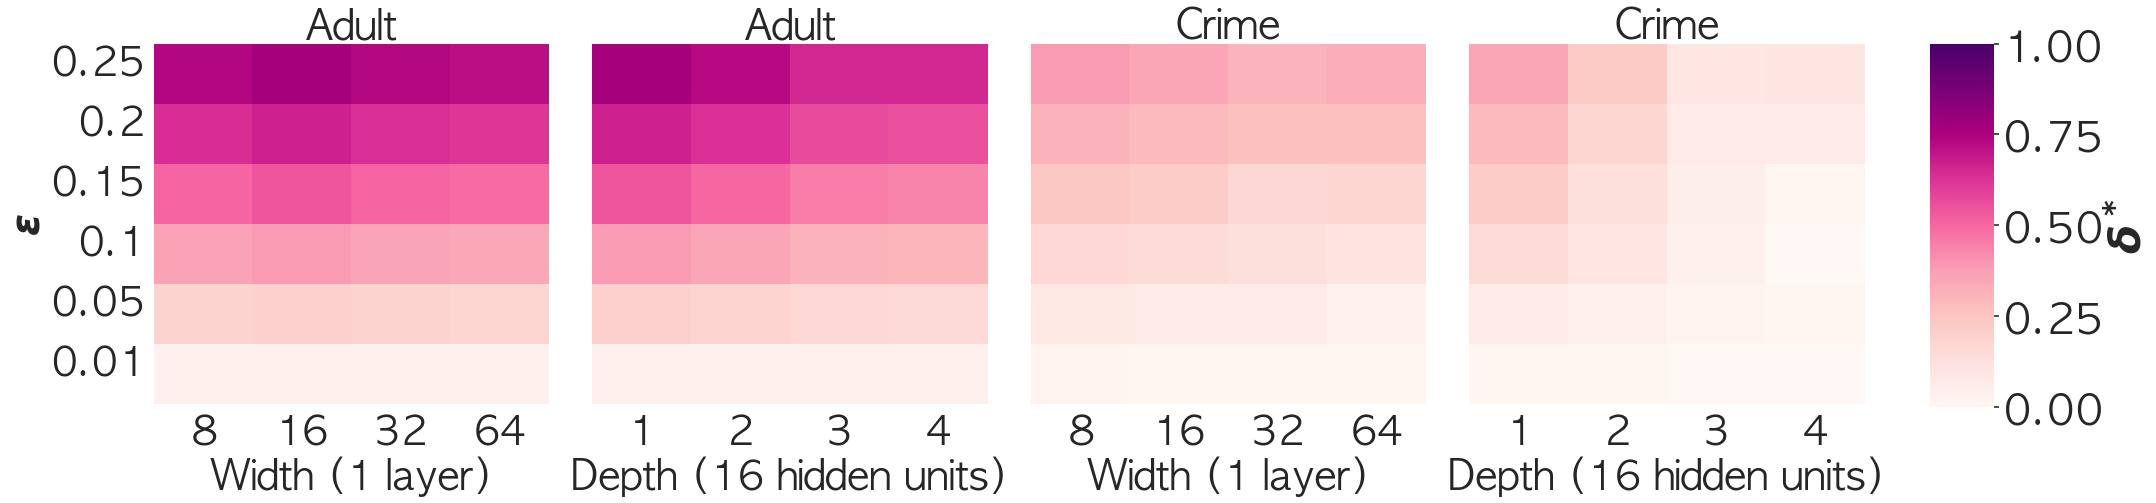

In [111]:
from matplotlib.ticker import MultipleLocator

FONT_SIZE = 40

sns.set_style('white')
font = {'weight' : 'bold', "size":FONT_SIZE, "family":"serif", "serif":"AppleGothic"}
matplotlib.rc('font', **font)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8), sharex=False, sharey=True)
cbar_ax = fig.add_axes([.91, .23, .03, .63])

cmap = sns.color_palette("RdPu", as_cmap=True)

sns.heatmap(class_widths_data_points, cmap=cmap, ax=ax1,  cbar=False, vmin=0, vmax=1, cbar_ax=cbar_ax)

ax1.set_ylabel(r'$\epsilon$', fontsize=FONT_SIZE)
ax1.set_xlabel(r'Width (1 layer)', fontsize=FONT_SIZE)

ax1.set_xticks(np.asarray(range(len(class_widths))) + 0.5)
ax1.set_xticklabels(get_single_ints(class_widths), fontsize=FONT_SIZE, rotation=0)
ax1.set_yticks(np.asarray(range(len(class_epsilons))) + 0.25)
ax1.set_yticklabels(class_epsilons, fontsize=FONT_SIZE, rotation=0)
ax1.set_title('Adult', fontsize=FONT_SIZE)

# ======================

sns.heatmap(class_depths_data_points, cmap=cmap, ax=ax2, vmin=0, vmax=1, cbar_ax=cbar_ax)

ax2.set_xlabel(f'Depth ({CLASS_DEPTH_UNITS} hidden units)', fontsize=FONT_SIZE)


ax2.set_xticks(np.asarray(range(len(class_depths))) + 0.5)
ax2.set_xticklabels(range(1, len(class_depths)+1), fontsize=FONT_SIZE, rotation=0)
ax2.set_yticks(np.asarray(range(len(class_epsilons))) + 0.25)
ax2.set_yticklabels(class_epsilons, fontsize=FONT_SIZE, rotation=0)
ax2.set_title('Adult', fontsize=FONT_SIZE)


# ==================

sns.heatmap(reg_widths_data_points, cmap=cmap, ax=ax3,  cbar=False, vmin=0, vmax=1, cbar_ax=cbar_ax)

ax3.set_xlabel(r'Width (1 layer)', fontsize=FONT_SIZE)
ax3.set_xticks(np.asarray(range(len(reg_widths))) + 0.5)
ax3.set_xticklabels(get_single_ints(reg_widths), fontsize=FONT_SIZE, rotation=0)
ax3.set_yticks(np.asarray(range(len(reg_epsilons))) + 0.25)
ax3.set_yticklabels(reg_epsilons, fontsize=FONT_SIZE, rotation=0)
ax3.set_title('Crime', fontsize=FONT_SIZE)

# ======================

sns.heatmap(reg_depths_data_points, cmap=cmap, ax=ax4, vmin=0, vmax=1, cbar_ax=cbar_ax, cbar_kws={'label': r'$\delta^*$'})

ax4.set_xlabel(f'Depth ({REG_DEPTH_UNITS} hidden units)', fontsize=FONT_SIZE)
ax4.set_xticks(np.asarray(range(len(reg_depths))) + 0.5)
ax4.set_xticklabels(range(1, len(reg_depths)+1), fontsize=FONT_SIZE, rotation=0)
ax4.set_yticks(np.asarray(range(len(reg_epsilons))) + 0.25)
ax4.set_yticklabels(reg_epsilons, fontsize=FONT_SIZE, rotation=0)
ax4.set_title('Crime', fontsize=FONT_SIZE)

# ======================

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(f'figure_1_weighted_lp.jpeg', bbox_inches='tight')

# Mahalanobis heatmaps for Credit and German

In [105]:
CREDIT_DATASET = 'credit'
GERMAN_DATASET = 'german'
MODEL_NAME = 'vanilla'
CREDIT_DEPTH_UNITS = 16
GERMAN_DEPTH_UNITS = 16

In [106]:
def extract_credit_data_points(raw_data):
    credit_data = raw_data[(raw_data['params.dataset_name'] == CREDIT_DATASET) & (raw_data['params.time_limit'] == '180') & (raw_data['params.dist_metric'] == 'mahalanobis')]
    credit_epsilons = sorted(credit_data['params.verification_epsilon'].unique().tolist(), reverse=True)

    credit_n_layers = credit_data['params.n_units'].unique()
    credit_widths = get_sorted_widths(credit_n_layers)
    credit_depths = get_sorted_depths(credit_n_layers, CREDIT_DEPTH_UNITS)

    credit_widths_data = credit_data[credit_data['params.n_units'].isin(credit_widths)]

    credit_depths_data = credit_data[credit_data['params.n_units'].isin(credit_depths)]

    credit_widths_data_points = []
    for eps in credit_epsilons:
        row = []
        for w in credit_widths:
            d = credit_widths_data[(credit_widths_data['params.verification_epsilon'] == eps) & (credit_widths_data['params.n_units'] == w)]['metrics.max_confidence_diff']
            row.append(d.values[0])
        credit_widths_data_points.append(row)

    credit_depths_data_points = []
    for eps in credit_epsilons:
        row = []
        for d in credit_depths:
            d = credit_depths_data[(credit_depths_data['params.verification_epsilon'] == eps) & (credit_depths_data['params.n_units'] == d)]['metrics.max_confidence_diff']
            row.append(d.values[0])
        credit_depths_data_points.append(row)

    return credit_widths_data_points, credit_depths_data_points, credit_widths, credit_depths, credit_epsilons


raw_data = pd.concat([get_experiment(91), get_experiment(93)])
w1, d1, credit_widths, credit_depths, credit_epsilons = extract_credit_data_points(raw_data)

raw_data = pd.concat([get_experiment(99), get_experiment(100)])
w2, d2, _, _, _ = extract_credit_data_points(raw_data)

credit_widths_data_points = np.minimum(w1, w2)
credit_depths_data_points = np.minimum(d1, d2)

credit_widths_data_points, credit_depths_data_points

(array([[0.229014  , 0.09174222, 0.18481214, 0.00599415],
        [0.24344716, 0.19512135, 0.19502408, 0.24038119],
        [0.18963044, 0.21577467, 0.18271674, 0.19517834],
        [0.10451459, 0.15459319, 0.10027808, 0.09756597],
        [0.06001223, 0.04861536, 0.03127895, 0.02937338],
        [0.0086974 , 0.00683464, 0.00772301, 0.00217879]]),
 array([[0.09174222, 0.08696047, 0.06108597, 0.07099401],
        [0.19512135, 0.1847407 , 0.09829219, 0.04801633],
        [0.21577467, 0.12436964, 0.09892148, 0.07586207],
        [0.15459319, 0.07373796, 0.05415963, 0.04959467],
        [0.04861536, 0.03362671, 0.00920975, 0.02711143],
        [0.00683464, 0.00463564, 0.00646679, 0.00471546]]))

In [107]:
def extract_german_data_points(raw_data):
    german_data = raw_data[(raw_data['params.dataset_name'] == GERMAN_DATASET) & (raw_data['params.time_limit'] == '180') & (raw_data['params.dist_metric'] == 'mahalanobis')]
    german_epsilons = sorted(german_data['params.verification_epsilon'].unique().tolist(), reverse=True)

    german_n_layers = german_data['params.n_units'].unique()
    german_widths = get_sorted_widths(german_n_layers)
    german_depths = get_sorted_depths(german_n_layers, GERMAN_DEPTH_UNITS)

    german_widths_data = german_data[german_data['params.n_units'].isin(german_widths)]
    german_depths_data = german_data[german_data['params.n_units'].isin(german_depths)]

    german_widths_data_points = []
    for eps in german_epsilons:
        row = []
        for w in german_widths:
            d = german_widths_data[(german_widths_data['params.verification_epsilon'] == eps) & (german_widths_data['params.n_units'] == w)]['metrics.max_confidence_diff']
            row.append(d.values[0])
        german_widths_data_points.append(row)


    german_depths_data_points = []
    for eps in german_epsilons:
        row = []
        for d in german_depths[:-1]:
            d = german_depths_data[(german_depths_data['params.verification_epsilon'] == eps) & (german_depths_data['params.n_units'] == d)]['metrics.max_confidence_diff']
            row.append(d.values[0])
        german_depths_data_points.append(row)

    return german_widths_data_points, german_depths_data_points, german_widths, german_depths, german_epsilons

raw_data = pd.concat([get_experiment(91), get_experiment(93)])
w1, d1, german_widths, german_depths, german_epsilons = extract_german_data_points(raw_data)

raw_data = pd.concat([get_experiment(99), get_experiment(100)])
w2, d2, _, _, _ = extract_german_data_points(raw_data)

german_widths_data_points = np.minimum(w1, w2)
german_depths_data_points = np.minimum(d1, d2)

german_widths_data_points, german_depths_data_points

(array([[0.12789092, 0.15442892, 0.14653848, 0.12676222],
        [0.11180671, 0.13841025, 0.11154446, 0.08494072],
        [0.10203386, 0.0666517 , 0.04444701, 0.04243657],
        [0.05560589, 0.04570733, 0.05426669, 0.06059797],
        [0.03351204, 0.02850772, 0.02379075, 0.02649276],
        [0.00580863, 0.00730891, 0.00461774, 0.00601548]]),
 array([[ 1.54428916e-01, -3.37958869e-02,  3.23501011e-02],
        [ 1.38410250e-01,  5.58789907e-02,  5.77061144e-02],
        [ 6.66516974e-02, -3.42355200e-02,  1.84517892e-04],
        [ 4.57073333e-02,  3.15251241e-02,  5.77888064e-02],
        [ 2.85077163e-02,  2.63388147e-02,  1.06490094e-04],
        [ 7.30891244e-03,  5.40050552e-03,  6.63833035e-03]]))

<ipython-input-108-daeb382feac5>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


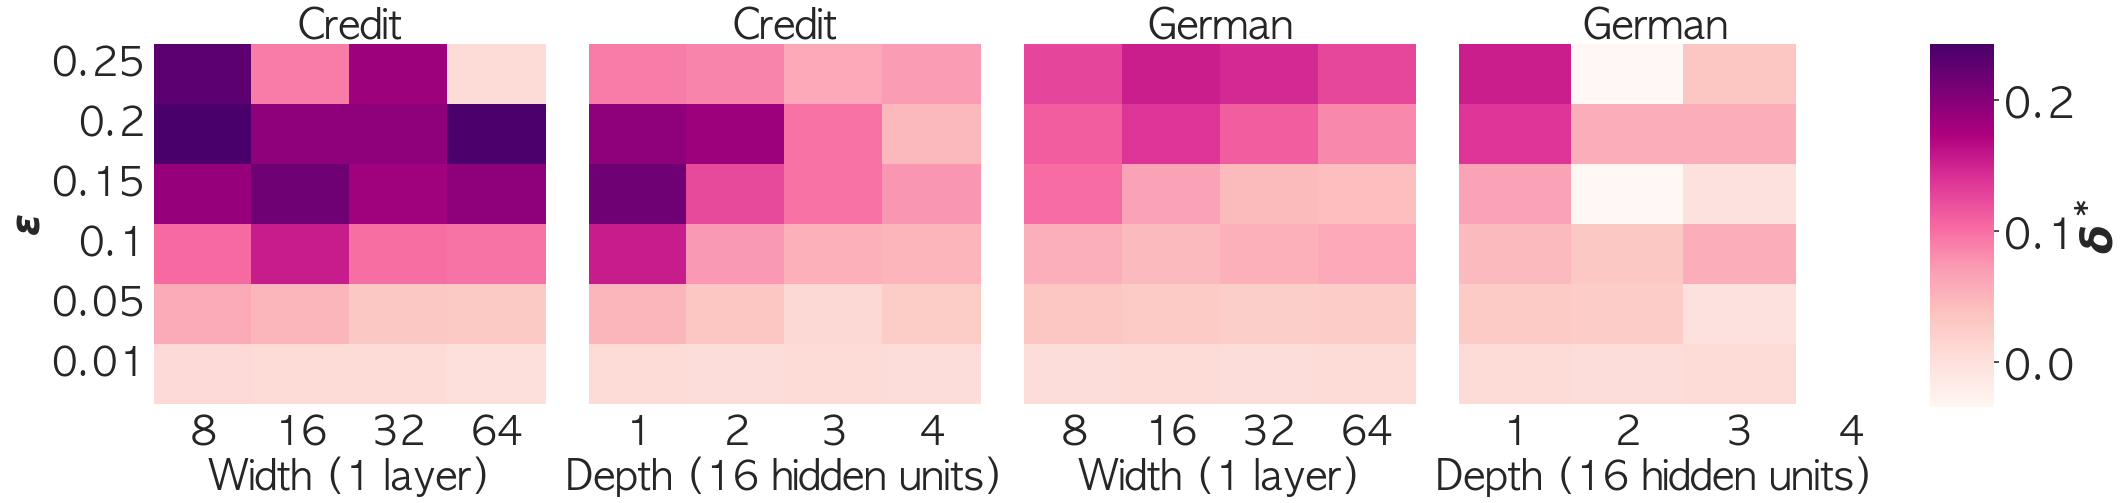

In [108]:
from matplotlib.ticker import MultipleLocator

FONT_SIZE = 40

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8), sharex=False, sharey=True)
cbar_ax = fig.add_axes([.91, .23, .03, .63])

cmap = sns.color_palette("RdPu", as_cmap=True)

VMIN = min(np.min(credit_widths_data_points), np.min(credit_depths_data_points), np.min(german_widths_data_points), np.min(german_depths_data_points))
VMAX = max(np.max(credit_widths_data_points), np.max(credit_depths_data_points), np.max(german_widths_data_points), np.max(german_depths_data_points))

# ======================

sns.heatmap(credit_widths_data_points, cmap=cmap, ax=ax1,  cbar=False, vmin=VMIN, vmax=VMAX, cbar_ax=cbar_ax)

ax1.set_ylabel(r'$\epsilon$', fontsize=FONT_SIZE)
ax1.set_xlabel(r'Width (1 layer)', fontsize=FONT_SIZE)

ax1.set_xticks(np.asarray(range(len(credit_widths))) + 0.5)
ax1.set_xticklabels(get_single_ints(credit_widths), fontsize=FONT_SIZE, rotation=0)
ax1.set_yticks(np.asarray(range(len(credit_epsilons))) + 0.25)
ax1.set_yticklabels(credit_epsilons, fontsize=FONT_SIZE, rotation=0)
ax1.set_title('Credit', fontsize=FONT_SIZE)

# ======================

sns.heatmap(credit_depths_data_points, cmap=cmap, ax=ax2, vmin=VMIN, vmax=VMAX, cbar_ax=cbar_ax)

ax2.set_ylabel(None)
ax2.set_xlabel(f'Depth ({CREDIT_DEPTH_UNITS} hidden units)', fontsize=FONT_SIZE)

ax2.set_xticks(np.asarray(range(len(credit_depths))) + 0.5)
ax2.set_xticklabels(range(1, len(credit_depths)+1), fontsize=FONT_SIZE, rotation=0)
ax2.set_yticks(np.asarray(range(len(credit_epsilons))) + 0.25)
ax2.set_yticklabels(credit_epsilons, fontsize=FONT_SIZE, rotation=0)
ax2.set_title('Credit', fontsize=FONT_SIZE)

# ======================

sns.heatmap(german_widths_data_points, cmap=cmap, ax=ax3,  cbar=False, vmin=VMIN, vmax=VMAX, cbar_ax=cbar_ax)

ax3.set_ylabel(None)
ax3.set_xlabel(r'Width (1 layer)', fontsize=FONT_SIZE)

ax3.set_xticks(np.asarray(range(len(german_widths))) + 0.5)
ax3.set_xticklabels(get_single_ints(german_widths), fontsize=FONT_SIZE, rotation=0)
ax3.set_yticks(np.asarray(range(len(german_epsilons))) + 0.25)
ax3.set_yticklabels(german_epsilons, fontsize=FONT_SIZE, rotation=0)
ax3.set_title('German', fontsize=FONT_SIZE)

# ======================

sns.heatmap(german_depths_data_points, cmap=cmap, ax=ax4, vmin=VMIN, vmax=VMAX, cbar_ax=cbar_ax, cbar_kws={'label': r'$\delta^*$'})

ax4.set_ylabel(None)
ax4.set_xlabel(f'Depth ({GERMAN_DEPTH_UNITS} hidden units)', fontsize=FONT_SIZE)

ax4.set_xticks(np.asarray(range(len(german_depths))) + 0.5)
ax4.set_xticklabels(range(1, len(german_depths)+1), fontsize=FONT_SIZE, rotation=0)
ax4.set_yticks(np.asarray(range(len(german_epsilons))) + 0.25)
ax4.set_yticklabels(german_epsilons, fontsize=FONT_SIZE, rotation=0)
ax4.set_title('German', fontsize=FONT_SIZE)

# # ======================

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(f'abl_credit_german_mahalanobis.jpeg', bbox_inches='tight')

# Weighted Lp for Credit and German

In [109]:
CREDIT_DATASET = 'credit'
GERMAN_DATASET = 'german'
MODEL_NAME = 'vanilla'

In [74]:
credit_data = raw_data[(raw_data['params.dataset_name'] == CREDIT_DATASET) & (raw_data['params.time_limit'] == '180') & (raw_data['params.dist_metric'] == 'weighted_lp')]
credit_epsilons = sorted(credit_data['params.verification_epsilon'].unique().tolist(), reverse=True)

credit_n_layers = credit_data['params.n_units'].unique()
credit_widths = get_sorted_widths(credit_n_layers)
CREDIT_DEPTH_UNITS = 16
credit_depths = get_sorted_depths(credit_n_layers, CREDIT_DEPTH_UNITS)

credit_widths_data = credit_data[credit_data['params.n_units'].isin(credit_widths)]

credit_depths_data = credit_data[credit_data['params.n_units'].isin(credit_depths)]

credit_widths_data_points = []
for eps in credit_epsilons:
    row = []
    for w in credit_widths:
        d = credit_widths_data[(credit_widths_data['params.verification_epsilon'] == eps) & (credit_widths_data['params.n_units'] == w)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    credit_widths_data_points.append(row)
    
    
credit_depths_data_points = []
for eps in credit_epsilons:
    row = []
    for d in credit_depths:
        d = credit_depths_data[(credit_depths_data['params.verification_epsilon'] == eps) & (credit_depths_data['params.n_units'] == d)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    credit_depths_data_points.append(row)
        
print(credit_widths_data_points)
print(credit_depths_data_points)

[[0.11065185995475951, 0.12312884013997, 0.12144300465892999, 0.11920381893882237], [0.08862600342620597, 0.09866483498033118, 0.0973154218965846, 0.09551377929358934], [0.06655348291858351, 0.07410862147154335, 0.0730712766195073, 0.07173871582732744], [0.044415065696535305, 0.04947124166805711, 0.048790240623447834, 0.04777141090575482], [0.022215980547453544, 0.024745655345139728, 0.024403586910238195, 0.023949539375642703], [0.004464972486365536, 0.006883350096345857, 0.0064643870900337325, 0.005573818777856376]]
[[0.12312884013997, 0.07334761266454987, 0.048223900555151356, 0.039806038435380664], [0.09866483498033118, 0.05873966582477991, 0.03858709770673746, 0.03184730003883196], [0.07410862147154335, 0.044080725433211954, 0.028943318523483308, 0.02388856135390327], [0.04947124166805711, 0.0293913520712199, 0.019304768792008153, 0.015937107695687958], [0.024745655345139728, 0.014710035497871532, 0.00966896191888067, 0.007984666417128222], [0.006883350096345857, 0.0029729574233548

In [75]:
german_data = raw_data[(raw_data['params.dataset_name'] == GERMAN_DATASET) & (raw_data['params.time_limit'] == '180') & (raw_data['params.dist_metric'] == 'weighted_lp')]
german_epsilons = sorted(german_data['params.verification_epsilon'].unique().tolist(), reverse=True)

german_n_layers = german_data['params.n_units'].unique()
german_widths = get_sorted_widths(german_n_layers)
GERMAN_DEPTH_UNITS = 16
german_depths = get_sorted_depths(german_n_layers, GERMAN_DEPTH_UNITS)

german_widths_data = german_data[german_data['params.n_units'].isin(german_widths)]

german_depths_data = german_data[german_data['params.n_units'].isin(german_depths)]

german_widths_data_points = []
for eps in german_epsilons:
    row = []
    for w in german_widths:
        d = german_widths_data[(german_widths_data['params.verification_epsilon'] == eps) & (german_widths_data['params.n_units'] == w)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    german_widths_data_points.append(row)
    
    
german_depths_data_points = []
for eps in german_epsilons:
    row = []
    for d in german_depths[:-1]:
        d = german_depths_data[(german_depths_data['params.verification_epsilon'] == eps) & (german_depths_data['params.n_units'] == d)]['metrics.max_confidence_diff']
        row.append(d.values[0])
    german_depths_data_points.append(row)
        
print(german_widths_data_points)
print(german_depths_data_points)

[[0.0743304911764042, 0.10820112275240346, 0.14797784072050196, 0.11346373183824701], [0.059655658070606105, 0.09207494070551336, 0.09825817669625765, 0.04065026784741088], [0.044859966119924155, 0.05687826505226906, 0.06257665346355112, 0.03293583539328726], [0.02996858783119813, 0.045297659762635833, 0.06149751965271663, 0.02637351609919583], [0.015002874600725802, 0.023410444150129106, 0.020494471125064667, 0.008841616160229548], [0.0030081247445065684, 0.013287763321131449, 0.0054274241811950175, 0.0038227635528664643]]
[[0.10820112275240346, 0.04822308431963357, 0.7432489020003182], [0.09207494070551336, 0.13987921500781753, 0.024572266250472097], [0.05687826505226906, 0.10391996916962248, 0.01310870941063437], [0.045297659762635833, 0.03312630336608149, 0.017200214167114564], [0.023410444150129106, 0.030372179120880638, 0.008481825322944121], [0.013287763321131449, 0.006801036230693218, 0.0009317980886123234]]


<ipython-input-110-a6e5029e1adb>:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


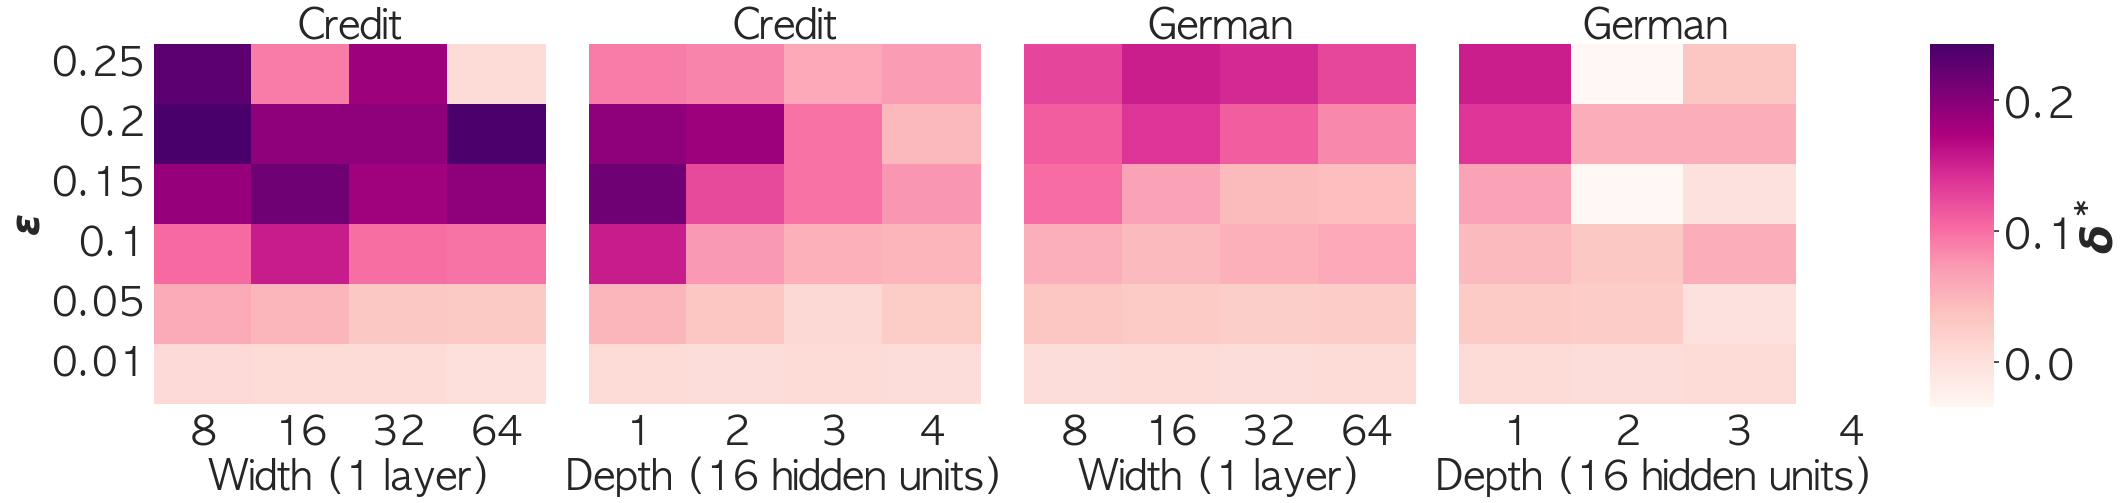

In [110]:
from matplotlib.ticker import MultipleLocator

FONT_SIZE = 40

sns.set_style('white')
font = {'weight' : 'bold', "size":FONT_SIZE, "family":"serif", "serif":"AppleGothic"}
matplotlib.rc('font', **font)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8), sharex=False, sharey=True)
cbar_ax = fig.add_axes([.91, .23, .03, .63])

cmap = sns.color_palette("RdPu", as_cmap=True)

VMIN = min(np.min(credit_widths_data_points), np.min(credit_depths_data_points), np.min(german_widths_data_points), np.min(german_depths_data_points))
VMAX = max(np.max(credit_widths_data_points), np.max(credit_depths_data_points), np.max(german_widths_data_points), np.max(german_depths_data_points))

# ======================

sns.heatmap(credit_widths_data_points, cmap=cmap, ax=ax1,  cbar=False, vmin=VMIN, vmax=VMAX, cbar_ax=cbar_ax)

ax1.set_ylabel(r'$\epsilon$', fontsize=FONT_SIZE)
ax1.set_xlabel(r'Width (1 layer)', fontsize=FONT_SIZE)

ax1.set_xticks(np.asarray(range(len(credit_widths))) + 0.5)
ax1.set_xticklabels(get_single_ints(credit_widths), fontsize=FONT_SIZE, rotation=0)
ax1.set_yticks(np.asarray(range(len(credit_epsilons))) + 0.25)
ax1.set_yticklabels(credit_epsilons, fontsize=FONT_SIZE, rotation=0)
ax1.set_title('Credit', fontsize=FONT_SIZE)

# ======================

sns.heatmap(credit_depths_data_points, cmap=cmap, ax=ax2, vmin=VMIN, vmax=VMAX, cbar_ax=cbar_ax)

ax2.set_ylabel(None)
ax2.set_xlabel(f'Depth ({CREDIT_DEPTH_UNITS} hidden units)', fontsize=FONT_SIZE)

ax2.set_xticks(np.asarray(range(len(credit_depths))) + 0.5)
ax2.set_xticklabels(range(1, len(credit_depths)+1), fontsize=FONT_SIZE, rotation=0)
ax2.set_yticks(np.asarray(range(len(credit_epsilons))) + 0.25)
ax2.set_yticklabels(credit_epsilons, fontsize=FONT_SIZE, rotation=0)
ax2.set_title('Credit', fontsize=FONT_SIZE)


# ======================

sns.heatmap(german_widths_data_points, cmap=cmap, ax=ax3,  cbar=False, vmin=VMIN, vmax=VMAX, cbar_ax=cbar_ax)

ax3.set_ylabel(None)
ax3.set_xlabel(r'Width (1 layer)', fontsize=FONT_SIZE)

ax3.set_xticks(np.asarray(range(len(german_widths))) + 0.5)
ax3.set_xticklabels(get_single_ints(german_widths), fontsize=FONT_SIZE, rotation=0)
ax3.set_yticks(np.asarray(range(len(german_epsilons))) + 0.25)
ax3.set_yticklabels(german_epsilons, fontsize=FONT_SIZE, rotation=0)
ax3.set_title('German', fontsize=FONT_SIZE)

# ======================

sns.heatmap(german_depths_data_points, cmap=cmap, ax=ax4, vmin=VMIN, vmax=VMAX, cbar_ax=cbar_ax, cbar_kws={'label': r'$\delta^*$'})

ax4.set_ylabel(None)
ax4.set_xlabel(f'Depth ({GERMAN_DEPTH_UNITS} hidden units)', fontsize=FONT_SIZE)

ax4.set_xticks(np.asarray(range(len(german_depths))) + 0.5)
ax4.set_xticklabels(range(1, len(german_depths)+1), fontsize=FONT_SIZE, rotation=0)
ax4.set_yticks(np.asarray(range(len(german_epsilons))) + 0.25)
ax4.set_yticklabels(german_epsilons, fontsize=FONT_SIZE, rotation=0)
ax4.set_title('German', fontsize=FONT_SIZE)

# # ======================

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(f'abl_credit_german_weighted_lp.jpeg', bbox_inches='tight')

# Time cutoff analysis

In [115]:
raw_data = get_experiment(103)
MODEL_NAME = 'vanilla'

DATASET_NAME = 'adult'

pal = sns.color_palette("tab10")

In [116]:
def plot_cutoff_analysis_for_dataset(dataset_name, raw_data, plot_title, show_legend=False):
    data = raw_data[(raw_data['params.dataset_name'] == dataset_name) & (raw_data['params.epsilon'] == '0.2')]
    data['params.time_limit'] = data['params.time_limit'].astype(float)
    time_cutoff = data['params.time_limit'].sort_values().unique().tolist()
    
    n_layers = data['params.n_units'].unique()
    n_layers = [
        '[8]',
        '[24]',
        '[64]',
        '[8, 8]',
        '[8, 8, 8, 8]',
    ]

    all_data = []
    all_names = []
    all_builds = []
    for n in n_layers:
        d = data[data['params.n_units'] == n].sort_values('params.time_limit')['metrics.max_confidence_diff'].tolist()
        all_data.append(d)

        all_names.append(f'FC-{n}')

        bt = data[data['params.n_units'] == n].sort_values('params.time_limit')['metrics.problem_build_time'].tolist()
        all_builds.append(bt)

    print(all_data)


    import numpy as np
    import matplotlib.pyplot as plt 
    from matplotlib import gridspec

    matplotlib.rc('font', **font)

    fig = plt.figure(figsize=(14, 10)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
    print(gs)

    ax0 = plt.subplot(gs[0])
    ax0.set_title(plot_title)
    for i in range(len(all_builds)):
        sns.boxplot(all_builds[i], color=pal[i])
    ax0.set_xlabel('Build Time (Seconds)')
    ax0.get_yaxis().set_visible(False)

    ax1 = plt.subplot(gs[1])
    sns.set_style('white')
    for i in range(len(all_data)):
        if show_legend:
            sns.lineplot(x=time_cutoff, y=all_data[i], linewidth=10, ax=ax1, label=all_names[i], color=pal[i])
        else:
            sns.lineplot(x=time_cutoff, y=all_data[i], linewidth=10, ax=ax1, color=pal[i], legend=False)
    ax1.set_xlabel('Solve Time Cutoff (Seconds)')
    ax1.set_ylabel(r'$\delta_*$')
    if show_legend:
        font2 = {'weight' : 'bold', "size":28, "family":"serif"}
        ax1.legend(prop=font2)
    sns.despine()

    plt.tight_layout()
    plt.savefig(f'time_cutoffs_analysis_{dataset_name}.jpeg', bbox_inches='tight')

<ipython-input-116-9fcdadf762aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['params.time_limit'] = data['params.time_limit'].astype(float)
/Users/eliasbenussi/.pyenv/versions/3.8.2/envs/indie-fair-3.8.2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eliasbenussi/.pyenv/versions/3.8.2/envs/indie-fair-3.8.2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argume

[[0.865568006923293, 0.8303789385101797, 0.829928021269685, 0.9034788654773742], [0.829027004857719, 0.8938494683688721, 0.8218910103055598, 0.8428399610474084], [0.8710213654682692, 0.8505060408625971, 0.8853796208087115, 0.8853770444435469], [0.8040691402962945, 0.7836093666129715, 0.8406302856876933, 0.7837791010469893], [0.0, 0.0, 0.0, 0.0]]
GridSpec(2, 1, height_ratios=[1, 4])


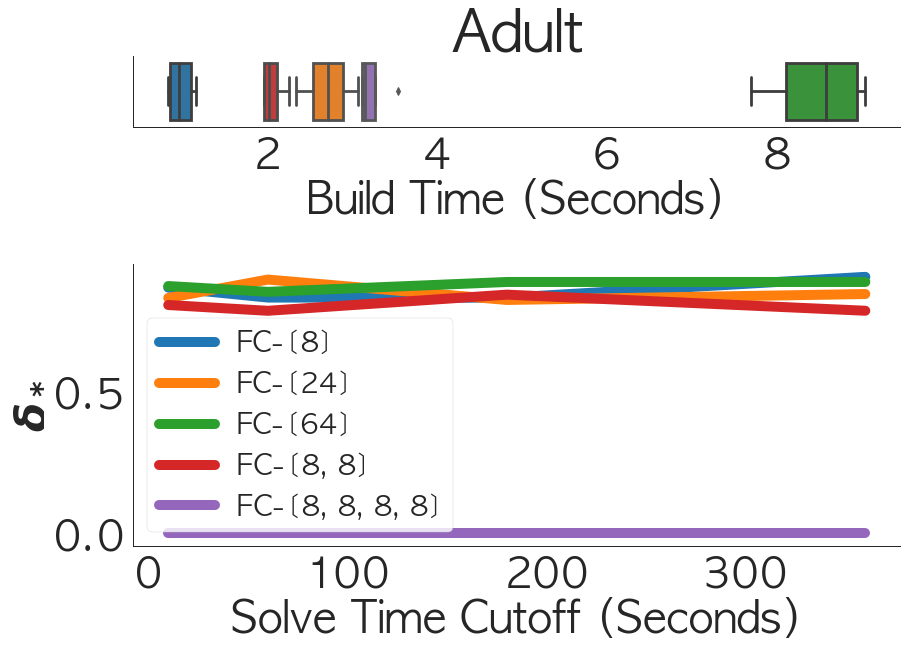

In [117]:
plot_cutoff_analysis_for_dataset('adult', raw_data, 'Adult', show_legend=True)

<ipython-input-116-9fcdadf762aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['params.time_limit'] = data['params.time_limit'].astype(float)
/Users/eliasbenussi/.pyenv/versions/3.8.2/envs/indie-fair-3.8.2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eliasbenussi/.pyenv/versions/3.8.2/envs/indie-fair-3.8.2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argume

[[0.0077205079123576215, 0.0017241540277890544, 0.23646852216546202, 0.21205558350070353], [0.09148820740691754, 0.0752476548966058, 0.2257081595375774, 0.12514308906863592], [0.09077588012098867, 0.11505896294424471, 0.15009795335782308, 0.09723070393894674], [0.053809956153192506, 0.10507293627409715, 0.12759791257519087, 0.03986973364163737], [-2.7755575615628914e-17, -2.7755575615628914e-17, -2.7755575615628914e-17, -2.7755575615628914e-17]]
GridSpec(2, 1, height_ratios=[1, 4])


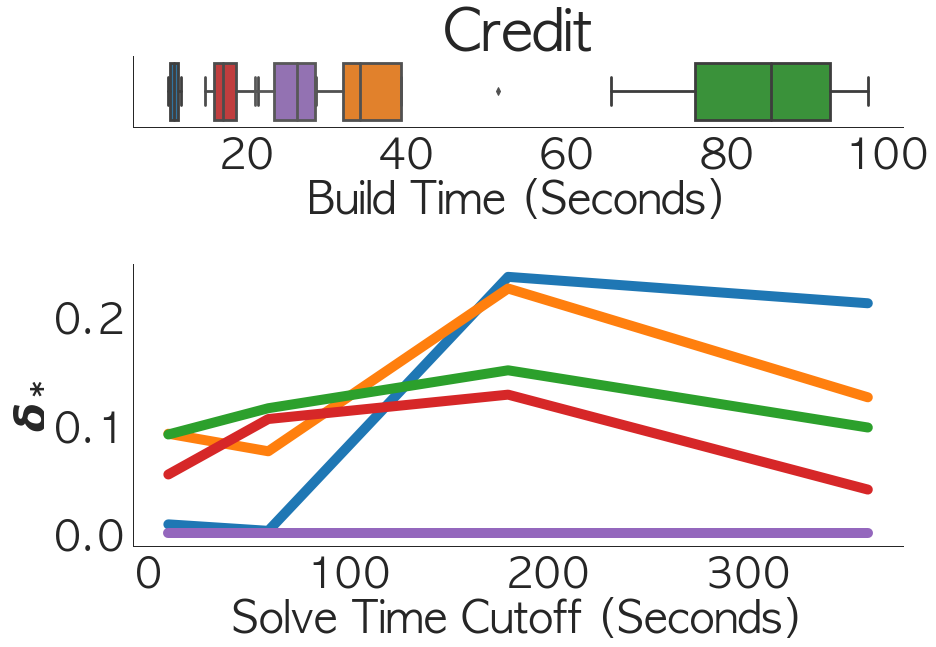

In [118]:
plot_cutoff_analysis_for_dataset('credit', raw_data, 'Credit')

<ipython-input-116-9fcdadf762aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['params.time_limit'] = data['params.time_limit'].astype(float)
/Users/eliasbenussi/.pyenv/versions/3.8.2/envs/indie-fair-3.8.2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eliasbenussi/.pyenv/versions/3.8.2/envs/indie-fair-3.8.2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argume

[[0.11374339496680914, 0.10718397633683631, 0.08702138419020589, 0.11292371694767833], [0.9144989985687986, 0.06254645927849001, 0.09290370972881346, 0.12330602132657136], [0.9710084285898186, 0.031098281722458987, 0.09497357964576894, 0.08721804840583458], [0.034305419486165944, 0.0684756026562601, 0.08073336094573469, 0.08914102658166856], [0.5421036371481939, 0.02444502890746597, 0.06769039074346236, 0.07337966669516344]]
GridSpec(2, 1, height_ratios=[1, 4])


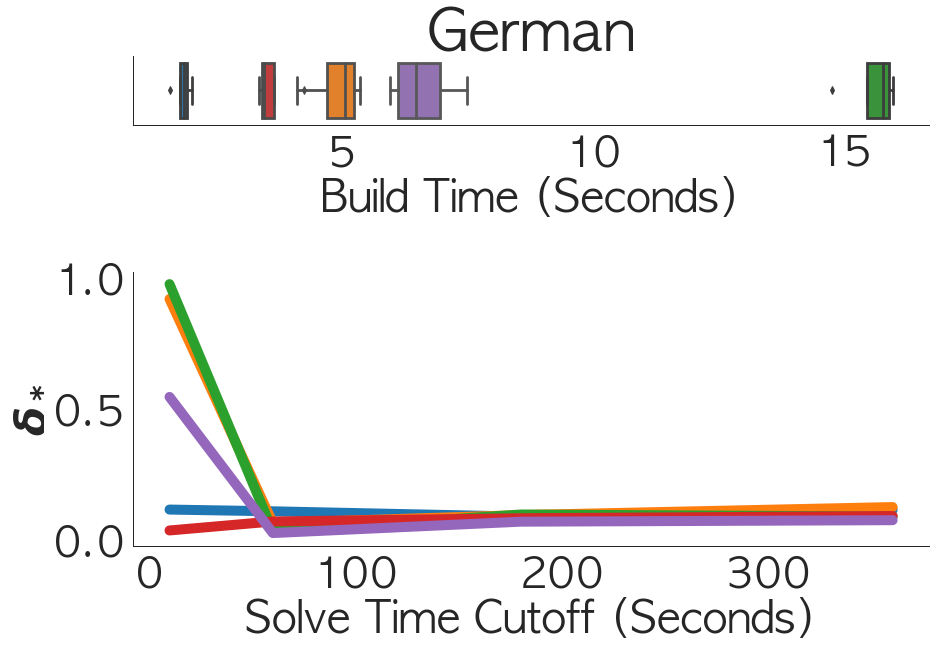

In [120]:
plot_cutoff_analysis_for_dataset('german', raw_data, 'German')

<ipython-input-116-9fcdadf762aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['params.time_limit'] = data['params.time_limit'].astype(float)
/Users/eliasbenussi/.pyenv/versions/3.8.2/envs/indie-fair-3.8.2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eliasbenussi/.pyenv/versions/3.8.2/envs/indie-fair-3.8.2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argume

[[0.5070196052618166, 0.44520804903638406, 0.47393181690360786, 0.4026762190283868], [0.33199990178174726, 0.30954363115909966, 0.5043664868173328, 0.5176041217229543], [0.7419973245541468, 0.5620747027247913, 0.45546774021152614, 0.5076121675855763], [0.12024921816206055, 0.25793367981291604, 0.3063162346316973, 0.28726339933905554], [0.1799142508211618, 0.13051377817071888, 0.17386497121782812, 0.17321476877697056]]
GridSpec(2, 1, height_ratios=[1, 4])


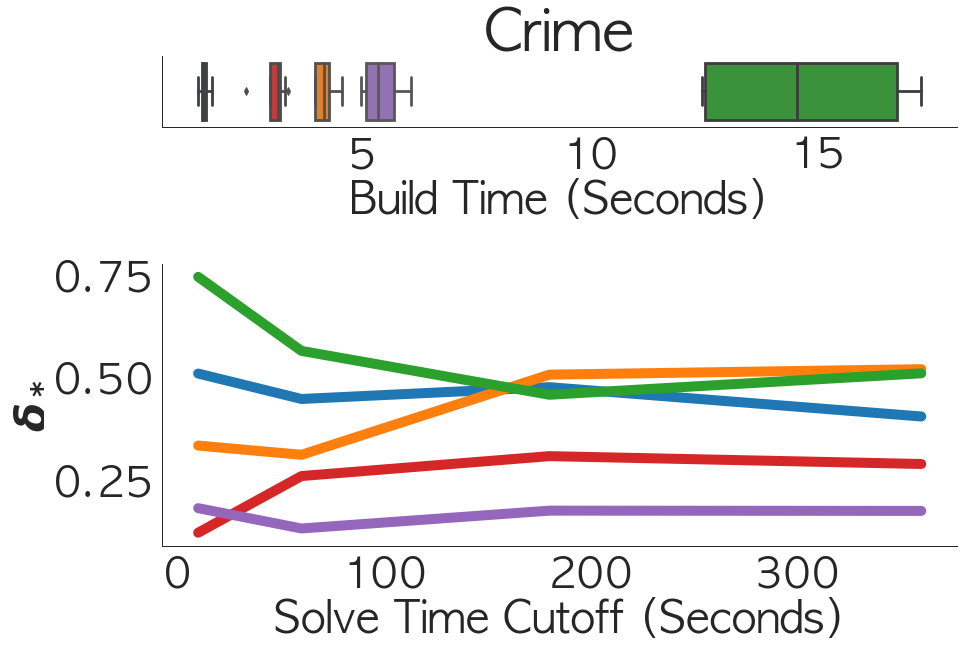

In [121]:
# raw_data = get_experiment(101)
plot_cutoff_analysis_for_dataset('crime', raw_data, 'Crime')

# Training Experiments

Change the `EXPERIMENT_ID` to the value of the Mlflow experiment created by the script `training_experiments.sh`. Note, if you don't have the Gurobi solver installed, modify script to use CBC (these are the only two supported solvers at them moment).

In [54]:
EXPERIMENT_ID = 106
raw_data = get_experiment(EXPERIMENT_ID)

vanilla_raw_data = raw_data
pgd_raw_data = raw_data
milp_raw_data = raw_data

### Adult

In [47]:
DATASET_NAME = 'adult'

FAIRNESS_METRIC = 'metrics.max_confidence_diff'
BALANCED_ACCURACY_METRIC = 'metrics.balanced_accuracy'
ACCURACY_METRIC = 'metrics.accuracy'
EPS = 0.2
TIME_LIMIT = 180
EPSs = [0.2]
N_UNITS = ['[8]', '[8, 8]', '[16]', '[16, 16]', '[24]', '[64]']

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS) & (vanilla_raw_data['params.time_limit'] == 180)]
adult_balanced_acc_vanilla = vanilla[BALANCED_ACCURACY_METRIC]
adult_acc_vanilla = vanilla[ACCURACY_METRIC]
adult_model_deltas_vanilla = vanilla[FAIRNESS_METRIC]

pgd = pgd_raw_data[(pgd_raw_data['params.dataset_name'] == DATASET_NAME) & pgd_raw_data['params.epsilon'].isin(EPSs) & (pgd_raw_data['params.model_name'] == 'PGD') & pgd_raw_data['params.n_units'].isin(N_UNITS) & (pgd_raw_data['params.time_limit'] == 180)]
adult_balanced_acc_adv = pgd[BALANCED_ACCURACY_METRIC]
adult_acc_adv = pgd[ACCURACY_METRIC]
adult_model_deltas_adv = pgd[FAIRNESS_METRIC]

milp = milp_raw_data[(milp_raw_data['params.dataset_name'] == DATASET_NAME) & milp_raw_data['params.epsilon'].isin(EPSs) & (milp_raw_data['params.model_name'] == 'MILP') & milp_raw_data['params.n_units'].isin(N_UNITS)]
adult_balanced_acc_milp = milp[BALANCED_ACCURACY_METRIC]
adult_acc_milp = milp[ACCURACY_METRIC]
adult_model_deltas_milp = milp[FAIRNESS_METRIC]

In [44]:
print(f'Vanilla Balanced Accuracy: {np.mean(adult_balanced_acc_vanilla):.3f} ± {np.std(adult_balanced_acc_vanilla):.3f}')
print(f'Vanilla Accuracy: {np.mean(adult_acc_vanilla):.3f} ± {np.std(adult_acc_vanilla):.3f}')
print(f'Vanilla Delta: {np.mean(adult_model_deltas_vanilla):.3f} ± {np.std(adult_model_deltas_vanilla):.3f}')
eod_vanilla = vanilla['metrics.equalized_odds_diff']
print(f'Vanilla Equalized Odds Diff: {np.mean(eod_vanilla):.3f} ± {np.std(eod_vanilla):.3f}')
dpd_vanilla = vanilla['metrics.demographic_parity_diff']
print(f'Vanilla Demographic Parity Diff: {np.mean(dpd_vanilla):.3f} ± {np.std(dpd_vanilla):.3f}')
print()

print(f'PGD Balanced Accuracy: {np.mean(adult_balanced_acc_adv):.3f} ± {np.std(adult_balanced_acc_adv):.3f}')
print(f'PGD Accuracy: {np.mean(adult_acc_adv):.3f} ± {np.std(adult_acc_adv):.3f}')
print(f'PGD Delta: {np.mean(adult_model_deltas_adv):.3f} ± {np.std(adult_model_deltas_adv):.3f}')
eod_pgd = pgd['metrics.equalized_odds_diff']
print(f'PGD Equalized Odds Diff: {np.mean(eod_pgd):.3f} ± {np.std(eod_pgd):.3f}')
dpd_pgd = pgd['metrics.demographic_parity_diff']
print(f'PGD Demographic Parity Diff: {np.mean(dpd_pgd):.3f} ± {np.std(dpd_pgd):.3f}')
print()

print(f'MILP Balanced Accuracy: {np.mean(adult_balanced_acc_milp):.3f} ± {np.std(adult_balanced_acc_milp):.3f}')
print(f'MILP Accuracy: {np.mean(adult_acc_milp):.3f} ± {np.std(adult_acc_milp):.3f}')
print(f'MILP Delta: {np.mean(adult_model_deltas_milp):.3f} ± {np.std(adult_model_deltas_milp):.3f}')
eod_milp = milp['metrics.equalized_odds_diff']
print(f'MILP Equalized Odds Diff: {np.mean(eod_milp):.3f} ± {np.std(eod_milp):.3f}')
dpd_milp = milp['metrics.demographic_parity_diff']
print(f'MILP Demographic Parity Diff: {np.mean(dpd_milp):.3f} ± {np.std(dpd_milp):.3f}')

### Credit

In [48]:
DATASET_NAME = 'credit'

FAIRNESS_METRIC = 'metrics.max_confidence_diff'
BALANCED_ACCURACY_METRIC = 'metrics.balanced_accuracy'
ACCURACY_METRIC = 'metrics.accuracy'
EPS = 0.2
TIME_LIMIT = 180
EPSs = [0.2]
N_UNITS = ['[8]', '[8, 8]', '[16]', '[16, 16]', '[24]', '[64]']

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS) & (vanilla_raw_data['params.time_limit'] == 180)]
credit_balanced_acc_vanilla = vanilla[BALANCED_ACCURACY_METRIC]
credit_acc_vanilla = vanilla[ACCURACY_METRIC]
credit_model_deltas_vanilla = vanilla[FAIRNESS_METRIC]

pgd = pgd_raw_data[(pgd_raw_data['params.dataset_name'] == DATASET_NAME) & pgd_raw_data['params.epsilon'].isin(EPSs) & (pgd_raw_data['params.model_name'] == 'PGD') & pgd_raw_data['params.n_units'].isin(N_UNITS) & (pgd_raw_data['params.time_limit'] == 180)]
credit_balanced_acc_adv = pgd[BALANCED_ACCURACY_METRIC]
credit_acc_adv = pgd[ACCURACY_METRIC]
credit_model_deltas_adv = pgd[FAIRNESS_METRIC]

milp = milp_raw_data[(milp_raw_data['params.dataset_name'] == DATASET_NAME) & milp_raw_data['params.epsilon'].isin(EPSs) & (milp_raw_data['params.model_name'] == 'MILP') & milp_raw_data['params.n_units'].isin(N_UNITS)]
credit_balanced_acc_milp = milp[BALANCED_ACCURACY_METRIC]
credit_acc_milp = milp[ACCURACY_METRIC]
credit_model_deltas_milp = milp[FAIRNESS_METRIC]

In [46]:
print(f'Vanilla Balanced Accuracy: {np.mean(credit_balanced_acc_vanilla):.3f} ± {np.std(credit_balanced_acc_vanilla):.3f}')
print(f'Vanilla Accuracy: {np.mean(credit_acc_vanilla):.3f} ± {np.std(credit_acc_vanilla):.3f}')
print(f'Vanilla Delta: {np.mean(credit_model_deltas_vanilla):.3f} ± {np.std(credit_model_deltas_vanilla):.3f}')
eod_vanilla = vanilla['metrics.equalized_odds_diff']
print(f'Vanilla Equalized Odds Diff: {np.mean(eod_vanilla):.3f} ± {np.std(eod_vanilla):.3f}')
dpd_vanilla = vanilla['metrics.demographic_parity_diff']
print(f'Vanilla Demographic Parity Diff: {np.mean(dpd_vanilla):.3f} ± {np.std(dpd_vanilla):.3f}')
print()

print(f'PGD Balanced Accuracy: {np.mean(credit_balanced_acc_adv):.3f} ± {np.std(credit_balanced_acc_adv):.3f}')
print(f'PGD Accuracy: {np.mean(credit_acc_adv):.3f} ± {np.std(credit_acc_adv):.3f}')
print(f'PGD Delta: {np.mean(credit_model_deltas_adv):.3f} ± {np.std(credit_model_deltas_adv):.3f}')
eod_pgd = pgd['metrics.equalized_odds_diff']
print(f'PGD Equalized Odds Diff: {np.mean(eod_pgd):.3f} ± {np.std(eod_pgd):.3f}')
dpd_pgd = pgd['metrics.demographic_parity_diff']
print(f'PGD Demographic Parity Diff: {np.mean(dpd_pgd):.3f} ± {np.std(dpd_pgd):.3f}')
print()

print(f'MILP Balanced Accuracy: {np.mean(credit_balanced_acc_milp):.3f} ± {np.std(credit_balanced_acc_milp):.3f}')
print(f'MILP Accuracy: {np.mean(credit_acc_milp):.3f} ± {np.std(credit_acc_milp):.3f}')
print(f'MILP Delta: {np.mean(credit_model_deltas_milp):.3f} ± {np.std(credit_model_deltas_milp):.3f}')
eod_milp = milp['metrics.equalized_odds_diff']
print(f'MILP Equalized Odds Diff: {np.mean(eod_milp):.3f} ± {np.std(eod_milp):.3f}')
dpd_milp = milp['metrics.demographic_parity_diff']
print(f'MILP Demographic Parity Diff: {np.mean(dpd_milp):.3f} ± {np.std(dpd_milp):.3f}')

### German

In [49]:
DATASET_NAME = 'german'

FAIRNESS_METRIC = 'metrics.max_confidence_diff'
BALANCED_ACCURACY_METRIC = 'metrics.balanced_accuracy'
ACCURACY_METRIC = 'metrics.accuracy'
EPS = 0.2
TIME_LIMIT = 180
EPSs = [0.2]
N_UNITS = ['[8]', '[16]', '[16, 16]', '[24]', '[64]']

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS) & (vanilla_raw_data['params.time_limit'] == 180)]
german_balanced_acc_vanilla = vanilla[BALANCED_ACCURACY_METRIC]
german_acc_vanilla = vanilla[ACCURACY_METRIC]
german_model_deltas_vanilla = vanilla[FAIRNESS_METRIC]

pgd = pgd_raw_data[(pgd_raw_data['params.dataset_name'] == DATASET_NAME) & pgd_raw_data['params.epsilon'].isin(EPSs) & (pgd_raw_data['params.model_name'] == 'PGD') & pgd_raw_data['params.n_units'].isin(N_UNITS) & (pgd_raw_data['params.time_limit'] == 180)]
german_balanced_acc_adv = pgd[BALANCED_ACCURACY_METRIC]
german_acc_adv = pgd[ACCURACY_METRIC]
german_model_deltas_adv = pgd[FAIRNESS_METRIC]

milp = milp_raw_data[(milp_raw_data['params.dataset_name'] == DATASET_NAME) & milp_raw_data['params.epsilon'].isin(EPSs) & (milp_raw_data['params.model_name'] == 'MILP') & milp_raw_data['params.n_units'].isin(N_UNITS)]
german_balanced_acc_milp = milp[BALANCED_ACCURACY_METRIC]
german_acc_milp = milp[ACCURACY_METRIC]
german_model_deltas_milp = milp[FAIRNESS_METRIC]

In [48]:
print(f'Vanilla Balanced Accuracy: {np.mean(german_balanced_acc_vanilla):.3f} ± {np.std(german_balanced_acc_vanilla):.3f}')
print(f'Vanilla Accuracy: {np.mean(german_acc_vanilla):.3f} ± {np.std(german_acc_vanilla):.3f}')
print(f'Vanilla Delta: {np.mean(german_model_deltas_vanilla):.3f} ± {np.std(german_model_deltas_vanilla):.3f}')
eod_vanilla = vanilla['metrics.equalized_odds_diff']
print(f'Vanilla Equalized Odds Diff: {np.mean(eod_vanilla):.3f} ± {np.std(eod_vanilla):.3f}')
dpd_vanilla = vanilla['metrics.demographic_parity_diff']
print(f'Vanilla Demographic Parity Diff: {np.mean(dpd_vanilla):.3f} ± {np.std(dpd_vanilla):.3f}')
print()

print(f'PGD Balanced Accuracy: {np.mean(german_balanced_acc_adv):.3f} ± {np.std(german_balanced_acc_adv):.3f}')
print(f'PGD Accuracy: {np.mean(german_acc_adv):.3f} ± {np.std(german_acc_adv):.3f}')
print(f'PGD Delta: {np.mean(german_model_deltas_adv):.3f} ± {np.std(german_model_deltas_adv):.3f}')
eod_pgd = pgd['metrics.equalized_odds_diff']
print(f'PGD Equalized Odds Diff: {np.mean(eod_pgd):.3f} ± {np.std(eod_pgd):.3f}')
dpd_pgd = pgd['metrics.demographic_parity_diff']
print(f'PGD Demographic Parity Diff: {np.mean(dpd_pgd):.3f} ± {np.std(dpd_pgd):.3f}')
print()

print(f'MILP Balanced Accuracy: {np.mean(german_balanced_acc_milp):.3f} ± {np.std(german_balanced_acc_milp):.3f}')
print(f'MILP Accuracy: {np.mean(german_acc_milp):.3f} ± {np.std(german_acc_milp):.3f}')
print(f'MILP Delta: {np.mean(german_model_deltas_milp):.3f} ± {np.std(german_model_deltas_milp):.3f}')
eod_milp = milp['metrics.equalized_odds_diff']
print(f'MILP Equalized Odds Diff: {np.mean(eod_milp):.3f} ± {np.std(eod_milp):.3f}')
dpd_milp = milp['metrics.demographic_parity_diff']
print(f'MILP Demographic Parity Diff: {np.mean(dpd_milp):.3f} ± {np.std(dpd_milp):.3f}')

### Crime

In [51]:
DATASET_NAME = 'crime'

FAIRNESS_METRIC = 'metrics.max_confidence_diff'
BALANCED_ACCURACY_METRIC = 'metrics.MSE'
ACCURACY_METRIC = 'metrics.MSE'
EPS = 0.2
TIME_LIMIT = 180
EPSs = [0.2]
N_UNITS = ['[8]', '[16]', '[24]', '[8, 8]', '[16, 16]']

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS) & (vanilla_raw_data['params.time_limit'] == 180)]
crime_balanced_acc_vanilla = vanilla[BALANCED_ACCURACY_METRIC]
crime_acc_vanilla = vanilla[ACCURACY_METRIC]
crime_model_deltas_vanilla = vanilla[FAIRNESS_METRIC]

pgd = pgd_raw_data[(pgd_raw_data['params.dataset_name'] == DATASET_NAME) & pgd_raw_data['params.epsilon'].isin(EPSs) & (pgd_raw_data['params.model_name'] == 'PGD') & pgd_raw_data['params.n_units'].isin(N_UNITS) & (pgd_raw_data['params.time_limit'] == 180)]
crime_balanced_acc_adv = pgd[BALANCED_ACCURACY_METRIC]
crime_acc_adv = pgd[ACCURACY_METRIC]
crime_model_deltas_adv = pgd[FAIRNESS_METRIC]

milp = milp_raw_data[(milp_raw_data['params.dataset_name'] == DATASET_NAME) & milp_raw_data['params.epsilon'].isin(EPSs) & (milp_raw_data['params.model_name'] == 'MILP') & milp_raw_data['params.n_units'].isin(N_UNITS)]
crime_balanced_acc_milp = milp[BALANCED_ACCURACY_METRIC]
crime_acc_milp = milp[ACCURACY_METRIC]
crime_model_deltas_milp = milp[FAIRNESS_METRIC]

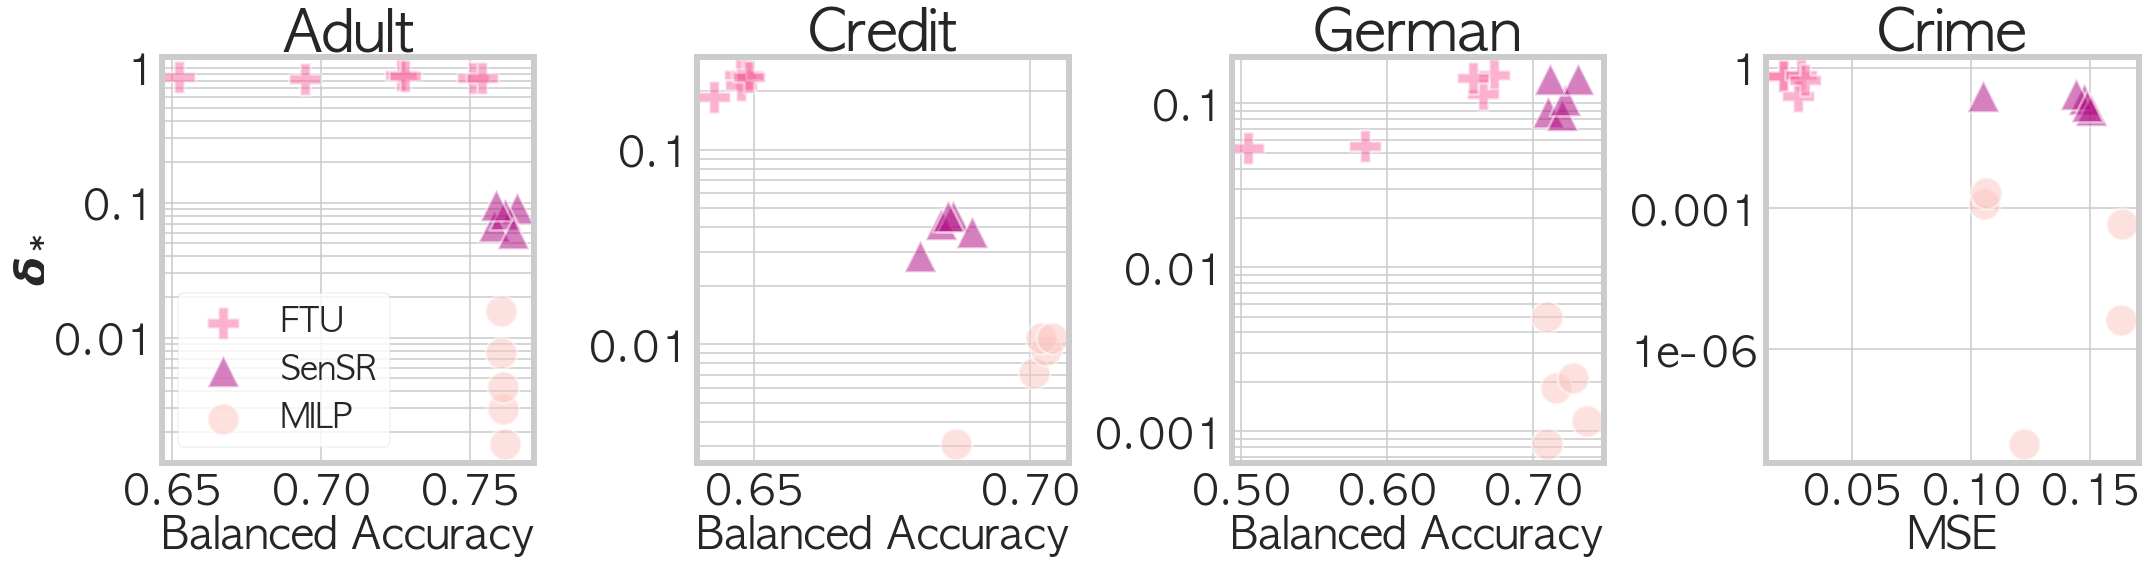

In [53]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

FONT_SIZE = 40

MARKER_SIZE = 1000

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8), sharex=False, sharey=False)

custom_pal = [sns.color_palette("RdPu", 3)[-2], 
             sns.color_palette("RdPu", 3)[-1],
             sns.color_palette("RdPu", 3)[0]]

custom_mark = ['P', '^', 'o']
grid_line_thickness = 1.25 # Smaller = Thinner
grid_line_spacing = 4 # Smaller = closer

sns.set_style("whitegrid", {'grid.linestyle': (0, (grid_line_thickness,grid_line_spacing))})

matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=6)

sns.set_palette(custom_pal)

# ======================

sns.scatterplot(x=adult_balanced_acc_vanilla, y=adult_model_deltas_vanilla, s=MARKER_SIZE, alpha=0.5,
                     label="FTU", marker=custom_mark[0], ax=ax1)

sns.scatterplot(x=adult_balanced_acc_adv, y=adult_model_deltas_adv, s=MARKER_SIZE, alpha=0.5,
                     label="SenSR", marker=custom_mark[1], ax=ax1)

sns.scatterplot(x=adult_balanced_acc_milp, y=adult_model_deltas_milp, s=MARKER_SIZE, alpha=0.5,
                     label="MILP", marker=custom_mark[2], ax=ax1)

ax1.legend(prop={'size': 32, 'weight' : 'bold', "family":"serif"})
ax1.set_ylabel(r"$\delta_*$")
ax1.set_yscale("log")
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xlabel("Balanced Accuracy")
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_title('Adult')
ax1.grid(True, which="both", ls="-")

# ======================

sns.scatterplot(x=credit_balanced_acc_vanilla, y=credit_model_deltas_vanilla, s=MARKER_SIZE, alpha=0.5,
                     label="FTU", marker=custom_mark[0], ax=ax2, legend=False)

sns.scatterplot(x=credit_balanced_acc_adv, y=credit_model_deltas_adv, s=MARKER_SIZE, alpha=0.5,
                     label="SenSR", marker=custom_mark[1], ax=ax2, legend=False)

sns.scatterplot(x=credit_balanced_acc_milp, y=credit_model_deltas_milp, s=MARKER_SIZE, alpha=0.5,
                     label="MILP", marker=custom_mark[2], ax=ax2, legend=False)

ax2.set_ylabel(None)
ax2.set_yscale("log")
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax2.yaxis.set_major_formatter(formatter)
ax2.set_xlabel("Balanced Accuracy")
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_title('Credit')
ax2.grid(True, which="both", ls="-")

# ======================

sns.scatterplot(x=german_balanced_acc_vanilla, y=german_model_deltas_vanilla, s=MARKER_SIZE, alpha=0.5,
                     label="FTU", marker=custom_mark[0], ax=ax3, legend=False)

sns.scatterplot(x=german_balanced_acc_adv, y=german_model_deltas_adv, s=MARKER_SIZE, alpha=0.5,
                     label="SenSR", marker=custom_mark[1], ax=ax3, legend=False)

sns.scatterplot(x=german_balanced_acc_milp, y=german_model_deltas_milp, s=MARKER_SIZE, alpha=0.5,
                     label="MILP", marker=custom_mark[2], ax=ax3, legend=False)

ax3.set_ylabel(None)
ax3.set_yscale("log")
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax3.yaxis.set_major_formatter(formatter)
ax3.set_xlabel("Balanced Accuracy")
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.set_title('German')
ax3.grid(True, which="both", ls="-")

# ======================

sns.scatterplot(x=crime_balanced_acc_vanilla, y=crime_model_deltas_vanilla, s=MARKER_SIZE, alpha=0.5,
                     label="FTU", marker=custom_mark[0], ax=ax4, legend=False)

sns.scatterplot(x=crime_balanced_acc_adv, y=crime_model_deltas_adv, s=MARKER_SIZE, alpha=0.5,
                     label="SenSR", marker=custom_mark[1], ax=ax4, legend=False)

sns.scatterplot(x=crime_balanced_acc_milp, y=crime_model_deltas_milp, s=MARKER_SIZE, alpha=0.5,
                     label="MILP", marker=custom_mark[2], ax=ax4, legend=False)

ax4.set_ylabel(None)
ax4.set_yscale("log")
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax4.yaxis.set_major_formatter(formatter)
ax4.set_xlabel("MSE")
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.set_title('Crime')
ax4.grid(True, which="both", ls="-")

# ======================

fig.tight_layout()
plt.savefig(f'figure_3.jpeg', bbox_inches='tight')

# Epsilon vs Delta plots

Change the `EXPERIMENT_ID` to the value of the Mlflow experiment created by the script `epsilon_vs_delta_experiment.sh`. Note, if you don't have the Gurobi solver installed, modify script to use CBC (these are the only two supported solvers at them moment).

In [56]:
EXPERIMENT_ID = 107
raw_data = get_experiment(EXPERIMENT_ID)

EPSs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4]

vanilla_raw_data = raw_data
pgd_raw_data = raw_data
milp_raw_data = raw_data

### Adult

In [128]:
DATASET_NAME = 'adult'

Y_VAR = 'metrics.max_confidence_diff'
X_VAR = 'params.verification_epsilon'
OLD_X_VAR = 'params.epsilon'
TIME_LIMIT = 180

N_UNITS = ['[24]']


vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS)]
x_vanilla = vanilla[X_VAR]
y_vanilla = vanilla[Y_VAR]

pgd = pgd_raw_data[(pgd_raw_data['params.dataset_name'] == DATASET_NAME) & pgd_raw_data['params.verification_epsilon'].isin(EPSs) & (pgd_raw_data['params.model_name'] == 'PGD') & pgd_raw_data['params.n_units'].isin(N_UNITS)]
x_pgd = pgd[X_VAR]
y_pgd = pgd[Y_VAR]

milp = milp_raw_data[(milp_raw_data['params.dataset_name'] == DATASET_NAME) & milp_raw_data['params.verification_epsilon'].isin(EPSs) & (milp_raw_data['params.model_name'] == 'MILP') & milp_raw_data['params.n_units'].isin(N_UNITS)]
x_milp = milp[X_VAR]
y_milp = milp[Y_VAR]

### Credit

In [129]:
DATASET_NAME = 'credit'

Y_VAR = 'metrics.max_confidence_diff'
X_VAR = 'params.verification_epsilon'
OLD_X_VAR = 'params.epsilon'
TIME_LIMIT = 180

N_UNITS = ['[24]']


vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS)]
x_credit_vanilla = vanilla[X_VAR]
y_credit_vanilla = vanilla[Y_VAR]

pgd = pgd_raw_data[(pgd_raw_data['params.dataset_name'] == DATASET_NAME) & pgd_raw_data['params.verification_epsilon'].isin(EPSs) & (pgd_raw_data['params.model_name'] == 'PGD') & pgd_raw_data['params.n_units'].isin(N_UNITS)]
x_credit_pgd = pgd[X_VAR]
y_credit_pgd = pgd[Y_VAR]

milp = milp_raw_data[(milp_raw_data['params.dataset_name'] == DATASET_NAME) & milp_raw_data['params.verification_epsilon'].isin(EPSs) & (milp_raw_data['params.model_name'] == 'MILP') & milp_raw_data['params.n_units'].isin(N_UNITS)]
x_credit_milp = milp[X_VAR]
y_credit_milp = milp[Y_VAR]

### German

In [130]:
DATASET_NAME = 'german'

Y_VAR = 'metrics.max_confidence_diff'
X_VAR = 'params.verification_epsilon'
OLD_X_VAR = 'params.epsilon'
TIME_LIMIT = 180

N_UNITS = ['[24]']

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS)]
vanilla = vanilla.sort_values(by='params.verification_epsilon')
x_german_vanilla = vanilla[X_VAR]
y_german_vanilla = vanilla[Y_VAR]
y_german_vanilla = y_german_vanilla.values.tolist()

pgd = pgd_raw_data[(pgd_raw_data['params.dataset_name'] == DATASET_NAME) & pgd_raw_data['params.verification_epsilon'].isin(EPSs) & (pgd_raw_data['params.model_name'] == 'PGD') & pgd_raw_data['params.n_units'].isin(N_UNITS)]
x_german_pgd = pgd[X_VAR]
y_german_pgd = pgd[Y_VAR]

milp = milp_raw_data[(milp_raw_data['params.dataset_name'] == DATASET_NAME) & milp_raw_data['params.verification_epsilon'].isin(EPSs) & (milp_raw_data['params.model_name'] == 'MILP') & milp_raw_data['params.n_units'].isin(N_UNITS)]
milp = milp.sort_values(by='params.verification_epsilon')
x_german_milp = milp[X_VAR]
y_german_milp = milp[Y_VAR]


### Crime

In [131]:
DATASET_NAME = 'crime'

Y_VAR = 'metrics.max_confidence_diff'
X_VAR = 'params.verification_epsilon'
OLD_X_VAR = 'params.epsilon'
TIME_LIMIT = 180

N_UNITS = ['[16]']

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS)]
x_crime_vanilla = vanilla[X_VAR]
y_crime_vanilla = vanilla[Y_VAR]

pgd = pgd_raw_data[(pgd_raw_data['params.dataset_name'] == DATASET_NAME) & pgd_raw_data['params.verification_epsilon'].isin(EPSs) & (pgd_raw_data['params.model_name'] == 'PGD') & pgd_raw_data['params.n_units'].isin(N_UNITS)]
x_crime_pgd = pgd[X_VAR]
y_crime_pgd = pgd[Y_VAR]

milp = milp_raw_data[(milp_raw_data['params.dataset_name'] == DATASET_NAME) & milp_raw_data['params.verification_epsilon'].isin(EPSs) & (milp_raw_data['params.model_name'] == 'MILP') & milp_raw_data['params.n_units'].isin(N_UNITS)]
x_crime_milp = milp[X_VAR]
y_crime_milp = milp[Y_VAR]

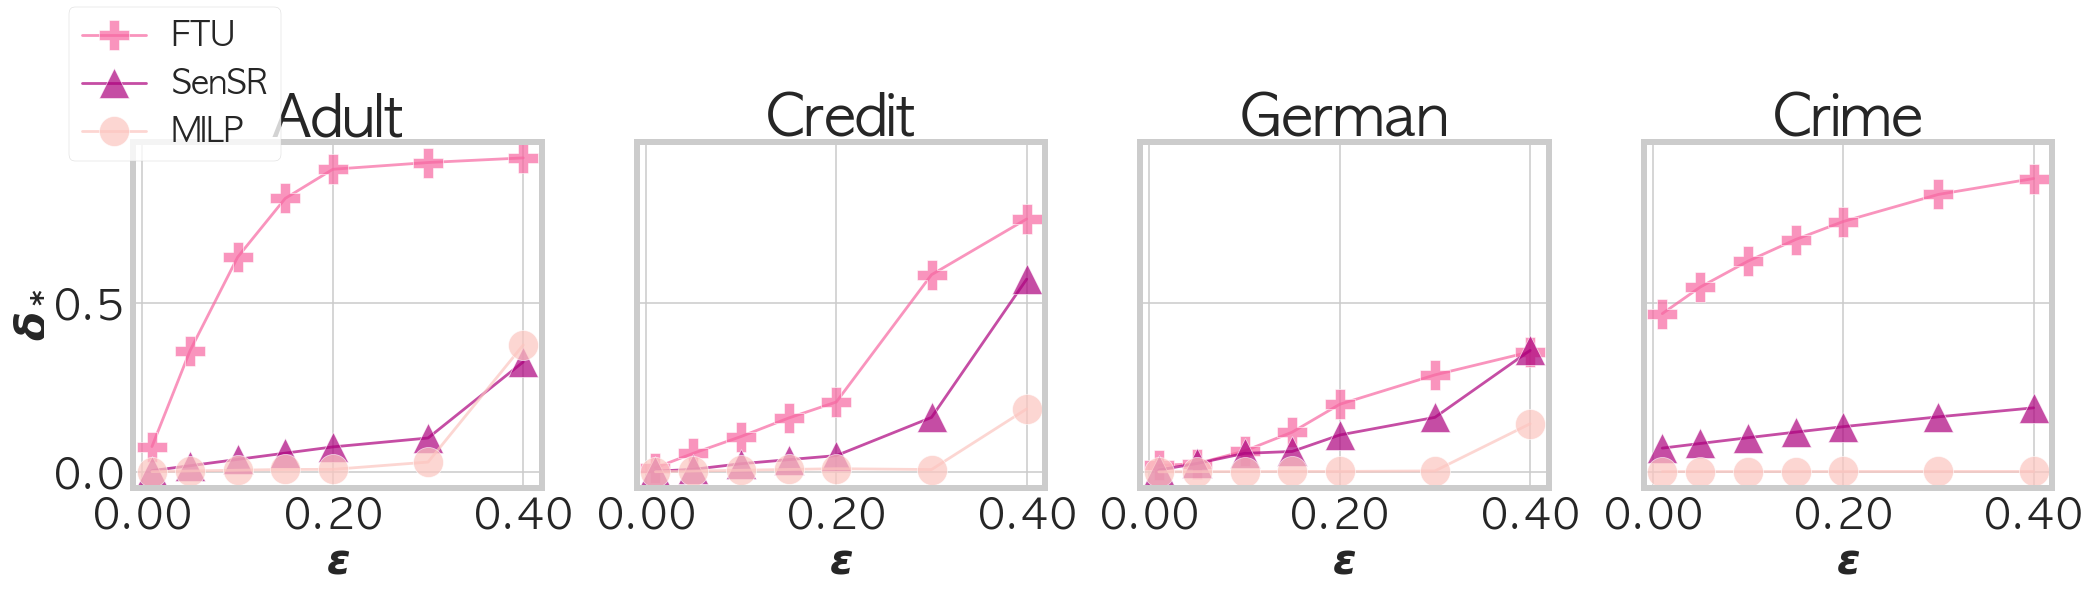

In [132]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter, FuncFormatter

FONT_SIZE = 40

MARKER_SIZE = 30

ALPHA = 0.7

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8), sharex=False, sharey=True)

matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=6)

custom_pal = [sns.color_palette("RdPu", 3)[-2], 
             sns.color_palette("RdPu", 3)[-1],
             sns.color_palette("RdPu", 3)[0]]

custom_mark = ['P', '^', 'o']
grid_line_thickness = 1.25 # Smaller = Thinner
grid_line_spacing = 4 # Smaller = closer

sns.set_style("whitegrid", {'grid.linestyle': (0, (grid_line_thickness,grid_line_spacing))})

matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=6)

sns.set_palette(custom_pal)


# ======================

sns.lineplot(x=x_vanilla, y=y_vanilla, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="FTU", marker=custom_mark[0], ax=ax1)

sns.lineplot(x=x_pgd, y=y_pgd, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="SenSR", marker=custom_mark[1], ax=ax1)

sns.lineplot(x=x_milp, y=y_milp, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="MILP", marker=custom_mark[2], ax=ax1)

ax1.set_ylabel(r"$\delta_*$")

ax1.set_xlabel(r"$\epsilon$")
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_title('Adult')
ax1.grid(True, which="both", ls="-")
ax1.legend(prop={'size': 32}, bbox_to_anchor=(0.4, 0.9))

# ======================

sns.lineplot(x=x_credit_vanilla, y=y_credit_vanilla, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="FTU", marker=custom_mark[0], ax=ax2, legend=False)

sns.lineplot(x=x_credit_pgd, y=y_credit_pgd, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="SenSR", marker=custom_mark[1], ax=ax2, legend=False)

sns.lineplot(x=x_credit_milp, y=y_credit_milp, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="MILP", marker=custom_mark[2], ax=ax2, legend=False)

ax2.set_ylabel(None)
ax2.set_xlabel(r"$\epsilon$")
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_title('Credit')
ax2.grid(True, which="both", ls="-")

# ======================

sns.lineplot(x=x_german_vanilla, y=y_german_vanilla, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="FTU", marker=custom_mark[0], ax=ax3, legend=False)

sns.lineplot(x=x_german_pgd, y=y_german_pgd, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="SenSR", marker=custom_mark[1], ax=ax3, legend=False)

sns.lineplot(x=x_german_milp, y=y_german_milp, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="MILP", marker=custom_mark[2], ax=ax3, legend=False)

ax3.set_ylabel(None)
ax3.set_xlabel(r"$\epsilon$")
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax3.set_yscale("log")
ax3.set_title('German')
ax3.grid(True, which="both", ls="-")

# ======================

sns.lineplot(x=x_crime_vanilla, y=y_crime_vanilla, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="FTU", marker=custom_mark[0], ax=ax4, legend=False)

sns.lineplot(x=x_crime_pgd, y=y_crime_pgd, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="SenSR", marker=custom_mark[1], ax=ax4, legend=False)

sns.lineplot(x=x_crime_milp, y=y_crime_milp, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="MILP", marker=custom_mark[2], ax=ax4, legend=False)

ax4.set_ylabel(None)
ax4.set_xlabel(r"$\epsilon$")
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.set_title('Crime')
ax4.grid(True, which="both", ls="-")

# ======================

fig.tight_layout()
plt.savefig(f'figure_4_eps_vs_delta.jpeg', bbox_inches='tight')

# Epsilon vs Delta with Embeddings

Change the `EXPERIMENT_ID` to the value of the Mlflow experiment created by the script `embedding_certification_experiments.sh`. Note, if you don't have the Gurobi solver installed, modify script to use CBC (these are the only two supported solvers at them moment).

In [75]:
EPSs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

Y_VAR = 'metrics.max_confidence_diff'
X_VAR = 'params.verification_epsilon'
OLD_X_VAR = 'params.epsilon'
TIME_LIMIT = '180'

N_UNITS = ['[16, 16]']

vanilla_raw_data = get_experiment(104)
vanilla_raw_data['params.verification_epsilon'] = vanilla_raw_data['params.verification_epsilon'].astype(float)

In [76]:
DATASET_NAME = 'adult'

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS)]
x_vanilla = vanilla[X_VAR]
y_vanilla = vanilla[Y_VAR]

In [77]:
DATASET_NAME = 'credit'

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS)]
x_credit_vanilla = vanilla[X_VAR]
y_credit_vanilla = vanilla[Y_VAR]

In [78]:
DATASET_NAME = 'german'

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS)]
vanilla = vanilla.sort_values(by='params.verification_epsilon')
x_german_vanilla = vanilla[X_VAR]
y_german_vanilla = vanilla[Y_VAR]

In [79]:
DATASET_NAME = 'crime'

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla') & vanilla_raw_data['params.n_units'].isin(N_UNITS)]
x_crime_vanilla = vanilla[X_VAR]
y_crime_vanilla = vanilla[Y_VAR]

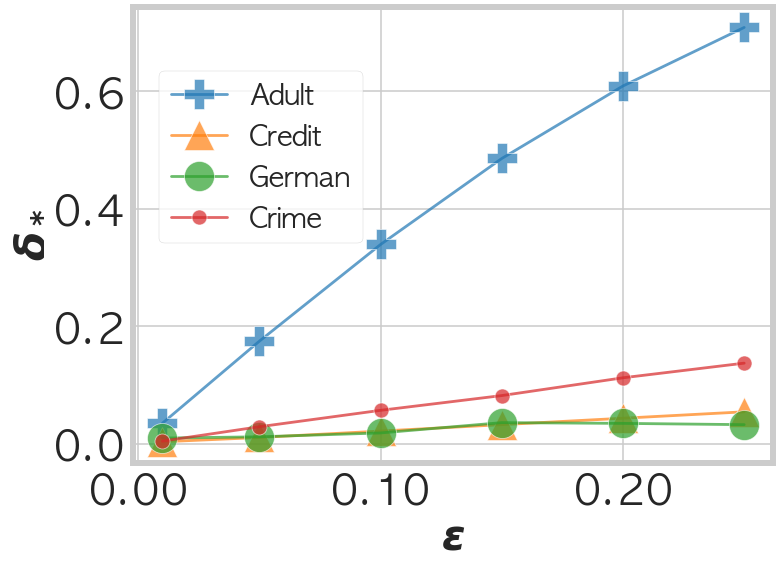

In [80]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter, FuncFormatter

FONT_SIZE = 40

MARKER_SIZE = 30

ALPHA = 0.7

fig, ax1 = plt.subplots(1, 1, figsize=(11,8), sharex=False, sharey=True)

custom_pal = sns.color_palette("tab10")

custom_mark = ['P', '^', 'o', '.']
grid_line_thickness = 1.25 # Smaller = Thinner
grid_line_spacing = 4 # Smaller = closer

sns.set_style("whitegrid", {'grid.linestyle': (0, (grid_line_thickness,grid_line_spacing))})
matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=6)
sns.set_palette(custom_pal)


# ======================

sns.lineplot(x=x_vanilla, y=y_vanilla, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="Adult", marker=custom_mark[0], ax=ax1)

sns.lineplot(x=x_credit_vanilla, y=y_credit_vanilla, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="Credit", marker=custom_mark[1], ax=ax1)

sns.lineplot(x=x_german_vanilla, y=y_german_vanilla, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="German", marker=custom_mark[2], ax=ax1, legend=False)

sns.lineplot(x=x_crime_vanilla, y=y_crime_vanilla, markersize=MARKER_SIZE, alpha=ALPHA,
                     label="Crime", marker=custom_mark[3], ax=ax1, legend=False)

ax1.set_ylabel(r"$\delta_*$")
ax1.set_xlabel(r"$\epsilon$")
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.grid(True, which="both", ls="-")
ax1.legend(prop={'size': 28}, bbox_to_anchor=(0.38, 0.45))

# ======================

fig.tight_layout()
plt.savefig(f'eps_vs_delta_embedding.jpeg', bbox_inches='tight')

# Number of units vs Delta

Change the `EXPERIMENT_ID` to the value of the Mlflow experiment created by the script `units_vs_delta_experiments.sh`. Note, if you don't have the Gurobi solver installed, modify script to use CBC (these are the only two supported solvers at them moment).

In [71]:
EXPERIMENT_ID = 105
vanilla_raw_data = get_experiment(EXPERIMENT_ID)

In [72]:
def sum_units(widths):
    int_widths = []
    for w in widths:
        es = [int(e) for e in w[1:-1].split(', ')]
        w = np.sum(es)
        int_widths.append(w)
    return int_widths

In [73]:
DATASET_NAME = 'crime'

Y_VAR = 'metrics.max_confidence_diff'
X_VAR = 'params.n_units'

EPSs = ['0.2']

vanilla = vanilla_raw_data[(vanilla_raw_data['params.dataset_name'] == DATASET_NAME) & vanilla_raw_data['params.verification_epsilon'].isin(EPSs) & (vanilla_raw_data['params.model_name'] == 'vanilla')]
x_vanilla = vanilla[X_VAR]

vanilla[X_VAR] = sum_units(x_vanilla.values.tolist())
data = vanilla[[X_VAR, Y_VAR]].sort_values(X_VAR)
x_vanilla = data[X_VAR]
y_vanilla = data[Y_VAR]


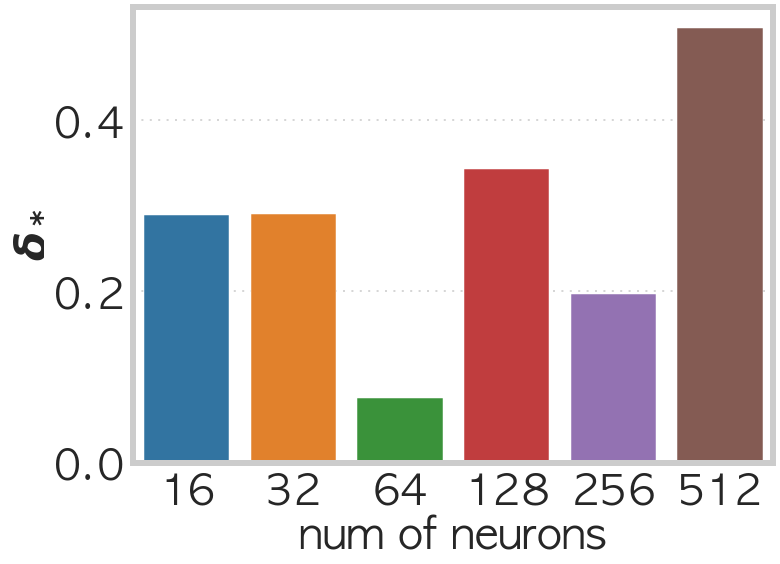

In [74]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter, FuncFormatter

FONT_SIZE = 40

MARKER_SIZE = 30

ALPHA = 0.7

fig, ax1 = plt.subplots(1, 1, figsize=(11,8), sharex=False, sharey=True)

grid_line_thickness = 1.25 # Smaller = Thinner
grid_line_spacing = 4 # Smaller = closer

sns.set_style("whitegrid", {'grid.linestyle': (0, (grid_line_thickness,grid_line_spacing))})
matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=6)

# ======================

sns.barplot(x=x_vanilla, y=y_vanilla)

ax1.set_ylabel(r"$\delta_*$")
ax1.set_xlabel("num of neurons")

# ======================

fig.tight_layout()
plt.savefig(f'neurons_vs_delta.jpeg', bbox_inches='tight')